# ``Taming Performance Variability''

### <font color='gray'> General processing/analysis of Network data.</font>

In [1]:
import os, sys
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
#import seaborn.apionly as sns
import seaborn as sns
import matplotlib.dates as md
from matplotlib import gridspec
import matplotlib.patches as patches
import datetime as dt
from collections import OrderedDict 
from collections import deque
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.quantile_regression import QuantReg
import warnings
from scipy.stats import norm
from IPython.display import IFrame
from IPython.display import Markdown, display
from IPython.display import FileLink, FileLinks
import calendar
import math
import re
import datetime

# warnings.filterwarnings(action='once')

# plot_show_and_save() defined in bench_lib/common.py makes this magic unnecessary 
# (all plots should use plot_show_and_save())
#%matplotlib inline

# Improve plot quality for retina displays
%config InlineBackend.figure_format = 'retina'

# Read all inputs from this directory
source_dir = "../data/raw-data/"
# Save all dataframes and plots into this directory 
dest_dir = "output/"

if not os.path.isdir(dest_dir):
    os.mkdir(dest_dir)

# db -- dictinary with keys - table names, values - dataframes with table data
db = {}

for f in os.listdir(source_dir):
    if ".csv" in f:
        db[os.path.splitext(f)[0]] = pd.read_csv(source_dir + f)
    
# Allows setting values in dataframe copies without warnings (default='warn')
pd.options.mode.chained_assignment = None 

# If vebose is set, additional debug info will be printed. Use this flag throughout the notebook
verbose = True

if verbose:
    print "Keys: ", db.keys()
    for k, df in db.iteritems():
        #print "Sample from %s:" % k 
        #print df.head(3), "\n\n" 
        print "Columns in %s:" % k, df.columns.tolist(), "\n"

# Include common helper functions. You can see the avilable files and their code 
# if you use JupyterHub's file browser to navigate to the specifed directory 
sys.path.append("bench-lib/")
from common import *

# The warning showing up in the output comes from statsmodels, not our code 

/opt/conda/envs/py27/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Keys:  ['disk_info', 'iperf3_info', 'iperf3_results', 'ping_results', 'env_info', 'membench_info', 'disk_results', 'fio_info', 'stream_info', 'network_info', 'mem_results', 'ping_info']
Columns in disk_info: ['run_uuid', 'timestamp', 'nodeid', 'nodeuuid', 'disk_name', 'disk_model', 'disk_serial', 'disk_size', 'npartitions', 'disk_type'] 

Columns in iperf3_info: ['run_uuid', 'timestamp', 'nodeid', 'nodeuuid', 'version', 'local_ip', 'local_port', 'remote_ip', 'remote_port', 'remote_nodeid', 'protocol', 'num_streams', 'buffer_size', 'omitted_intervals', 'duration', 'time_units'] 

Columns in iperf3_results: ['run_uuid', 'timestamp', 'nodeid', 'nodeuuid', 'reverse', 'retransmits', 'local_cpu_util', 'remote_cpu_util', 'median', 'max', 'min', 'mean', 'stdev', 'sum_sent', 'sum_received', 'units'] 

Columns in ping_results: ['run_uuid', 'timestamp', 'nodeid', 'nodeuuid', 'runtime', 'packets_sent', 'packets_received', 'packet_loss', 'max', 'min', 'mean', 'stdev', 'ipg', 'ewma', 'units'] 

Colu

In [2]:
# Now, all datasets are values in the db dictionary (keys correspond to dataset names used in the actual database).

# Print high-level info 
print "The earliest net perf sample: ", dt.datetime.fromtimestamp(db['ping_results']['timestamp'].min())
print "The latest net perf sample: ", dt.datetime.fromtimestamp(db['ping_results']['timestamp'].max())

print "Total number of samples: ", len(db['ping_results'])

The earliest net perf sample:  2017-11-26 13:06:50
The latest net perf sample:  2018-04-04 18:12:08
Total number of samples:  4320


In [3]:
# Merge with env_info, subset by run_success == 1
lat_all = subset_df(pd.merge(db['ping_results'], db["env_info"], on=["run_uuid", "nodeid", "nodeuuid", "timestamp"]), {"run_success":1})
lat_all = pd.merge(lat_all, db["ping_info"], on=["run_uuid", "nodeid", "nodeuuid", "timestamp"])
lat_all = pd.merge(lat_all, db["network_info"], on=["run_uuid", "nodeid", "nodeuuid", "timestamp"]) 

bw_all = subset_df(pd.merge(db['iperf3_results'], db["env_info"], on=["run_uuid", "nodeid", "nodeuuid", "timestamp"]), {"run_success":1})
bw_all = pd.merge(bw_all, db["iperf3_info"], on=["run_uuid", "nodeid", "nodeuuid", "timestamp"])
bw_all = pd.merge(bw_all, db["network_info"], on=["run_uuid", "nodeid", "nodeuuid", "timestamp"])

print "Latency:"
display(lat_all.sample(20).T)
print "Bandwidth:"
display(bw_all.sample(20).T)

Latency:


3188  \
run_uuid                       c3f1f3f2-3fa3-4650-97f8-6d7612ccd78e   
timestamp                                                1520428314   
nodeid                                                       ms0315   
nodeuuid                       311541c0-72db-11e4-85c8-179a28bd1b8c   
runtime                                                       370ms   
packets_sent                                                  10000   
packets_received                                              10000   
packet_loss                                                      0%   
max                                                           0.405   
min                                                           0.023   
mean                                                          0.026   
stdev                                                         0.009   
ipg                                                           0.037   
ewma                                                          0.026   
units                                                            ms   
gcc_ver                                                       5.4.0   
version_hash               9e67da94c8dc1846d9131ca4dbd0d6c5fb41307d   
total_mem                                                     62GiB   
mem_clock_speed                                        Unknown(ARM)   
arch                                                        aarch64   
run_success                                                       1   
site                                                           utah   
nthreads                                                          8   
nsockets                                                          1   
hw_type                                                        m400   
ping_version                                      iputils-s20121221   
ping_count                                                    10000   
ping_source_ip                                          192.168.1.2   
ping_dest_ip                                          192.168.1.100   
ping_dest_nodeid                                             ms0914   
ping_size                                                        56   
vlan_name                                                   vlan289   
vlan_ip                                                 192.168.1.2   
vlan_hwaddr                                       02:1f:28:9b:a9:3a   
vlan_driver                                     802.1Q VLAN Support   
vlan_driver_ver                                                 1.8   
if_name                                                    enp1s0d1   
if_hwaddr                                         fc:15:b4:1f:cc:13   
if_hwinfo                           MT27520 Family [ConnectX-3 Pro]   
if_speed                                                  10000Mb/s   
if_duplex                                                      Full   
if_port_type                                                   None   
if_driver                                                   mlx4_en   
if_driver_ver                                      2.2-1 (Feb 2014)   
if_bus_location                                        0000:01:00.0   
switch_path       bighp1:ms-chassis9-switchb ms-chassis3-switchb...   

                                                               3948  \
run_uuid                       baef90e9-9887-4e6e-adea-83fd3ec15e37   
timestamp                                                1522457340   
nodeid                                                    clnode055   
nodeuuid                       d26168ff-d7f1-11e4-b34b-000099989701   
runtime                                                       350ms   
packets_sent                                                  10000   
packets_received                                              10000   
packet_loss                                                      0%   
max                                                           0.142   
min            

Bandwidth:


6691  \
run_uuid                        d8a06ec5-37e4-46b6-811b-68c40af95f56   
timestamp                                                 1520986338   
nodeid                                                        ms0929   
nodeuuid                        c6274b3a-8fea-11e6-8c08-a53a3a50acf8   
reverse                                                            1   
retransmits                                                        0   
local_cpu_util                                               41.5271   
remote_cpu_util                                               24.686   
median                                                    9365570000   
max                                                       9371200000   
min                                                       9353180000   
mean                                                      9.3648e+09   
stdev                                                    3.80914e+06   
sum_sent                                                  9369920000   
sum_received                                              9364860000   
units                                                            bps   
gcc_ver                                                        5.4.0   
version_hash                9e67da94c8dc1846d9131ca4dbd0d6c5fb41307d   
total_mem                                                      64GiB   
mem_clock_speed                                              2400MHz   
arch                                                          x86_64   
run_success                                                        1   
site                                                            utah   
nthreads                                                          16   
nsockets                                                           1   
hw_type                                                         m510   
version                                                 iperf 3.0.11   
local_ip                                                 192.168.1.3   
local_port                                                     49664   
remote_ip                                              192.168.1.100   
remote_port                                                     5201   
remote_nodeid                                                 ms0914   
protocol                                                         TCP   
num_streams                                                        1   
buffer_size                                                   131072   
omitted_intervals                                                  1   
duration                                                          60   
time_units                                                         s   
vlan_name                                                    vlan289   
vlan_ip                                                  192.168.1.3   
vlan_hwaddr                                        02:a3:57:b2:f9:a4   
vlan_driver                                      802.1Q VLAN Support   
vlan_driver_ver                                                  1.8   
if_name                                                       eno1d1   
if_hwaddr                                          ec:b1:d7:85:1a:33   
if_hwinfo                            MT27520 Family [ConnectX-3 Pro]   
if_speed                                                   10000Mb/s   
if_duplex                                                       Full   
if_port_type                                                    None   
if_driver                                                    mlx4_en   
if_driver_ver                                              4.2-1.0.1   
if_bus_location                                         0000:09:00.0   
switch_path        bighp1:ms-chassis10-switchb bighp1:ms-chassis9...   

                                                                7682  \
run_uuid                        9b771ab8-1c1b-4d2f-9573-775297f107cd   
timestamp                      

In [4]:
# Clemson attempt to separate rack-local vs rack-non-local
def is_local_clemson(nodeid):
    if int(nodeid[-3:]) > 40 and int(nodeid[-3:]) < 97:
        return True
    else:
        return False

def is_not_local_clemson(nodeid):
    if int(nodeid[-3:]) > 40 and int(nodeid[-3:]) < 97:
        return False
    else:
        return True
    
# Utah separating rack-local vs rack-non-local
def is_local_utah(nodeid):
    return 'ms09' in nodeid

def is_not_local_utah(nodeid):
    return 'ms09' not in nodeid

# Wisc attempt to separate rack-local vs rack-non-local
def is_local_wisc(nodeid):
    if 'c220g1-0306' in nodeid:
        if int(nodeid[-2:]) > 20:
            return False
        else:
            return True
    else:
        return False

def is_not_local_wisc(nodeid):
    if 'c220g1-0306' in nodeid:
        if int(nodeid[-2:]) > 20:
            return True
        else:
            return False
    else:
        return True
    
# def is_rack_local(nodeid):
#     if 'clnode' in nodeid:
#         if int(nodeid[-3:]) > 40 and int(nodeid[-3:]) < 97:
#             return True
#         else:
#             return False
#     elif 'c220' in nodeid:
#         if 'c220g1-0306' in nodeid:
#             if int(nodeid[-2:]) > 20:
#                 return False
#             else:
#                 return True
#         else:
#             return False
#     elif 'ms' in nodeid:
#         return 'ms09' in nodeid

In [5]:
lat_all["test"] = "latency"
lat_all["directionality"] = ['forward'] * len(lat_all)

bw_all["test"] = "bandwidth"
bw_all["directionality"] = bw_all["reverse"].map({True: "reverse", False: "forward"})

raw_net_all, net_all = process_network(db)
print "Number of samples in raw_net_all:", len(raw_net_all)
print "Number of samples in net_all:", len(net_all)

Number of samples in raw_net_all: 12348
Number of samples in net_all: 12066


In [6]:
net_all.to_csv("network.csv", index=False)

In [7]:
#net_all.remote_nodeid.unique()

t = 1520456508

for idx, grp in bw_all.groupby(["remote_nodeid", "site"]):
    before_count = len(grp[grp["timestamp"] < t])
    after_count = len(grp[grp["timestamp"] >= t])
    print idx, len(grp), before_count, after_count
    
print " "

for idx, grp in lat_all.groupby(["ping_dest_nodeid", "site"]):
    before_count = len(grp[grp["timestamp"] < t])
    after_count = len(grp[grp["timestamp"] >= t])
    print idx, len(grp), before_count, after_count

('c220g1-030603', 'wisc') 1600 1178 422
('clnode061', 'clemson') 1750 1750 0
('clnode092', 'clemson') 416 0 416
('ms0914', 'utah') 4464 3470 994
 
('c220g1-030603', 'wisc') 800 589 211
('clnode061', 'clemson') 875 875 0
('clnode092', 'clemson') 208 0 208
('ms0914', 'utah') 2232 1735 497


In [8]:
for idx, grp in bw_all.groupby(["remote_ip", "site"]):
    print idx, len(grp)
    
print " "
for idx, grp in lat_all.groupby(["ping_dest_ip", "site"]):
    print idx, len(grp)

('192.168.1.100', 'clemson') 2166
('192.168.1.100', 'utah') 4466
('192.168.1.100', 'wisc') 1600
 
('192.168.1.100', 'clemson') 1083
('192.168.1.100', 'utah') 2233
('192.168.1.100', 'wisc') 800


In [9]:
print "Latency:"
for (hw_type), conf in lat_all.groupby(["hw_type"]):
    print "\tConfiguration: ", hw_type 
    print "\t\tNumber of samples for configuration: ", len(conf)
    print "\t\tMean of means: " + str(conf["mean"].mean()) + " ms"
print "\n"

print "Bandwidth:"
for (hw_type, reverse), conf in bw_all.groupby(["hw_type", "reverse"]):
    print "\tConfiguration: ", hw_type, reverse
    print "\t\tNumber of samples for configuration: ", len(conf)
    print "\t\tMean of means: " + str(conf["mean"].mean()) + " bps"

Latency:
	Configuration:  c220g1
		Number of samples for configuration:  370
		Mean of means: 0.0280918918919 ms
	Configuration:  c220g2
		Number of samples for configuration:  430
		Mean of means: 0.0279418604651 ms
	Configuration:  c6320
		Number of samples for configuration:  377
		Mean of means: 0.0349628647215 ms
	Configuration:  c8220
		Number of samples for configuration:  706
		Mean of means: 0.0327365439093 ms
	Configuration:  m400
		Number of samples for configuration:  1213
		Mean of means: 0.0283371805441 ms
	Configuration:  m510
		Number of samples for configuration:  1020
		Mean of means: 0.022087254902 ms


Bandwidth:
	Configuration:  c220g1 0
		Number of samples for configuration:  370
		Mean of means: 9389399459.46 bps
	Configuration:  c220g1 1
		Number of samples for configuration:  370
		Mean of means: 9389293486.49 bps
	Configuration:  c220g2 0
		Number of samples for configuration:  430
		Mean of means: 9389549302.33 bps
	Configuration:  c220g2 1
		Number of sample

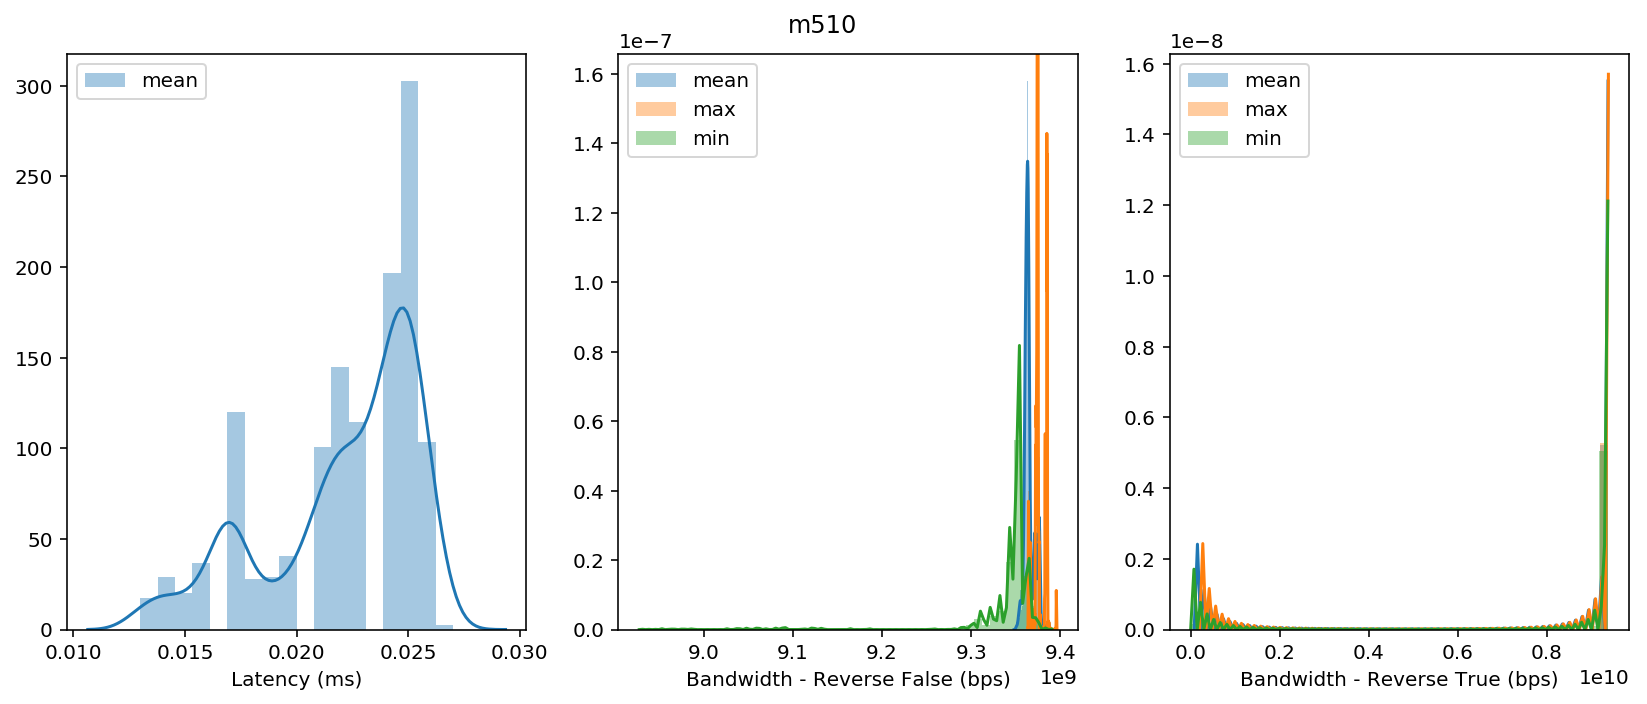

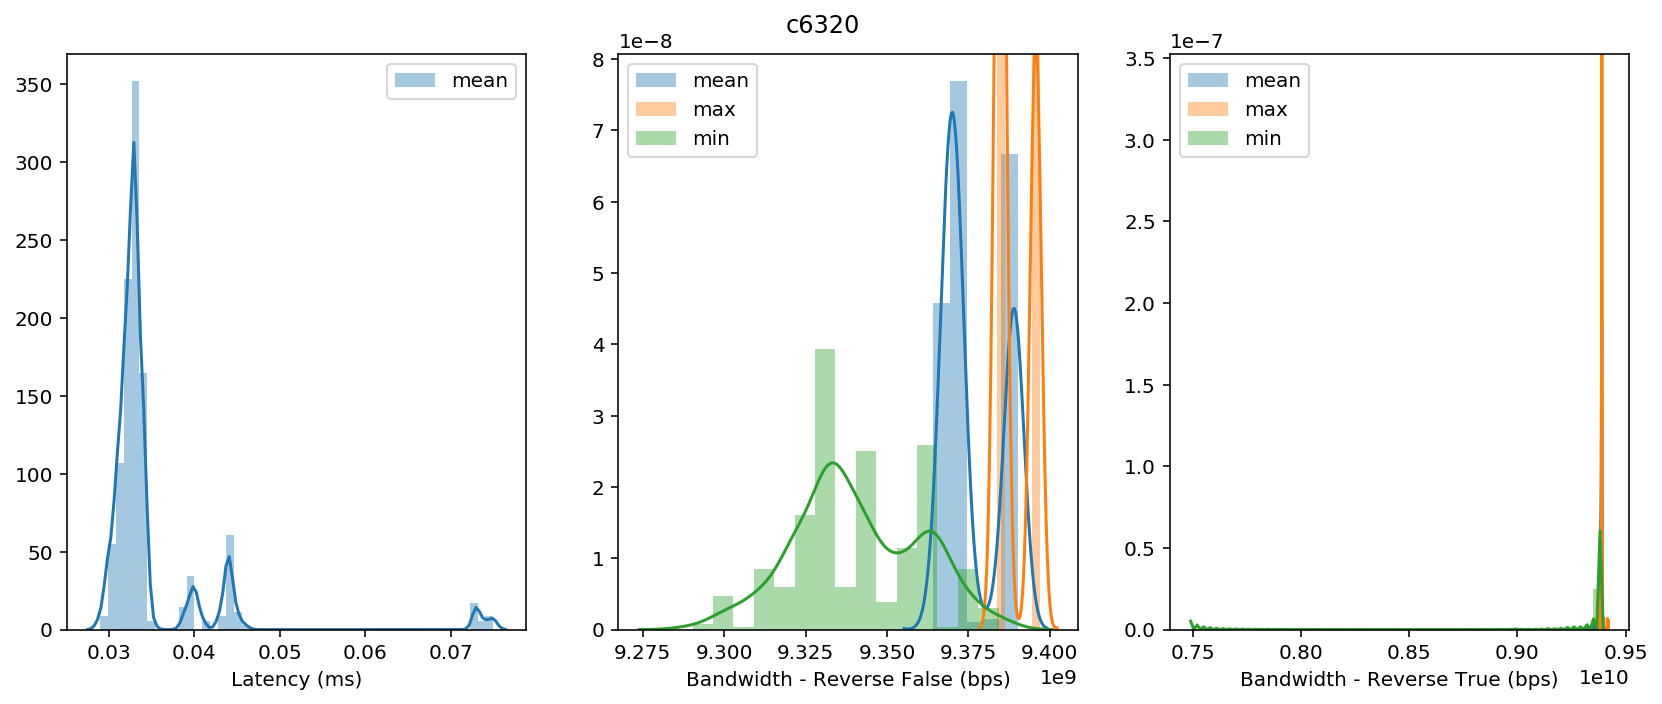

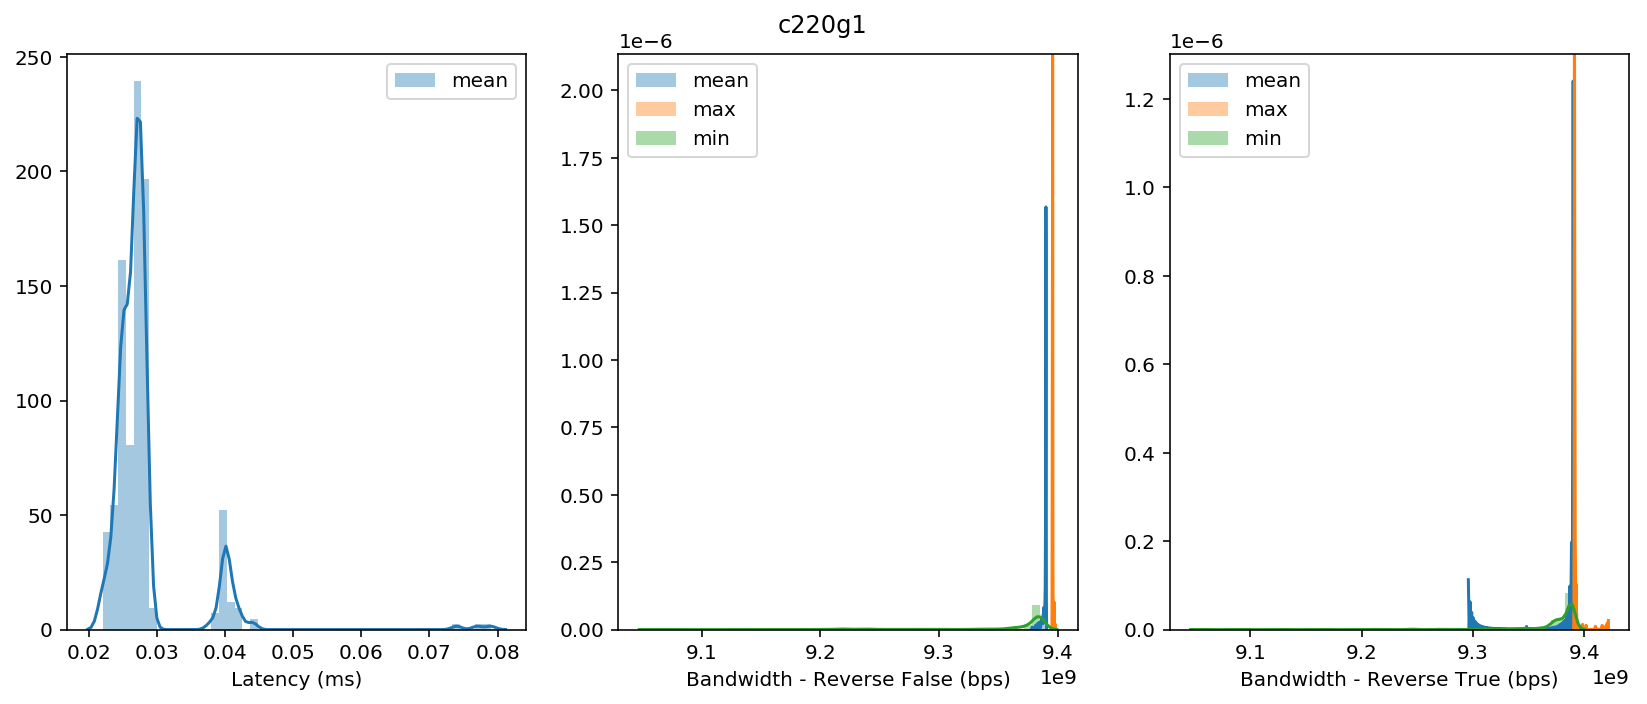

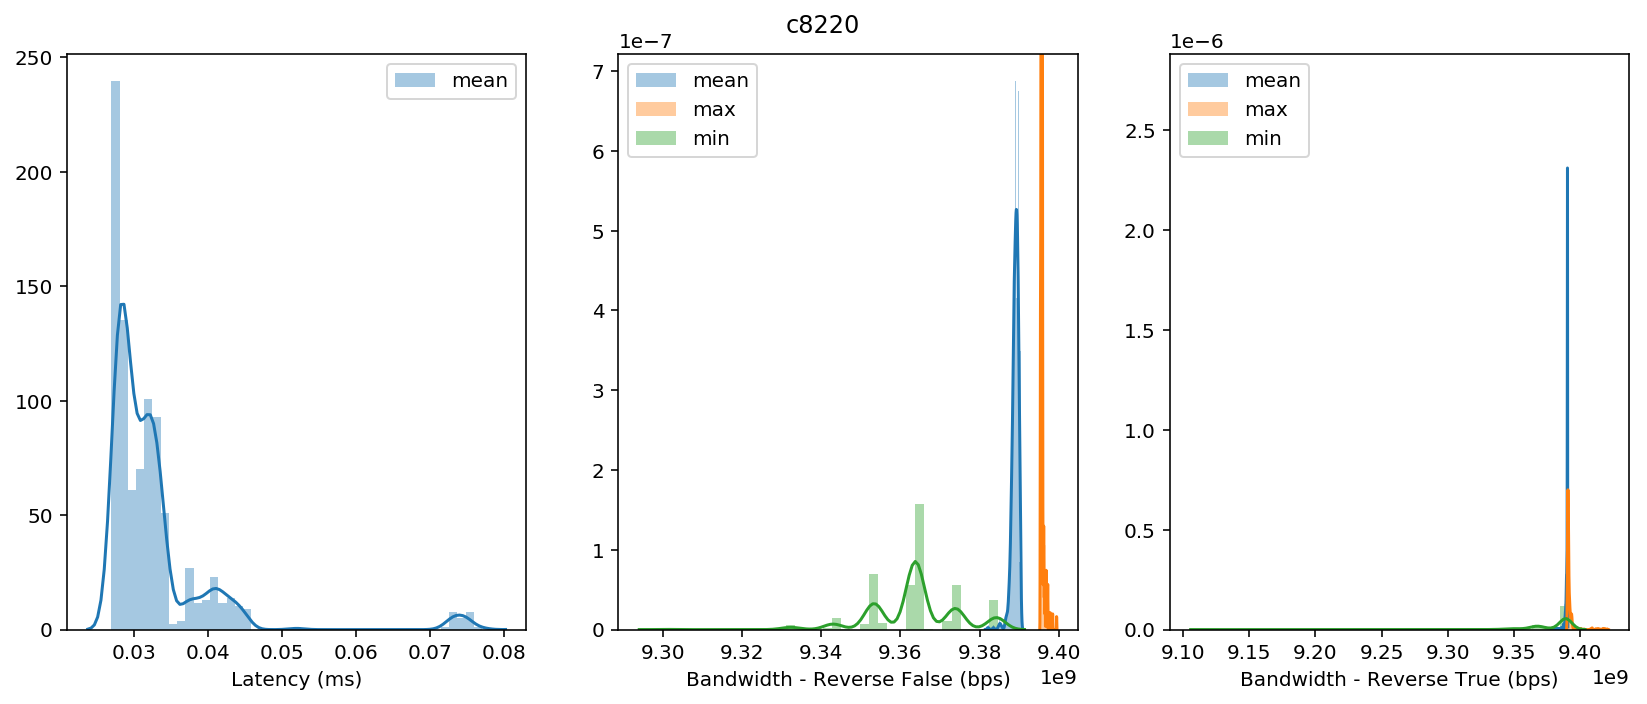

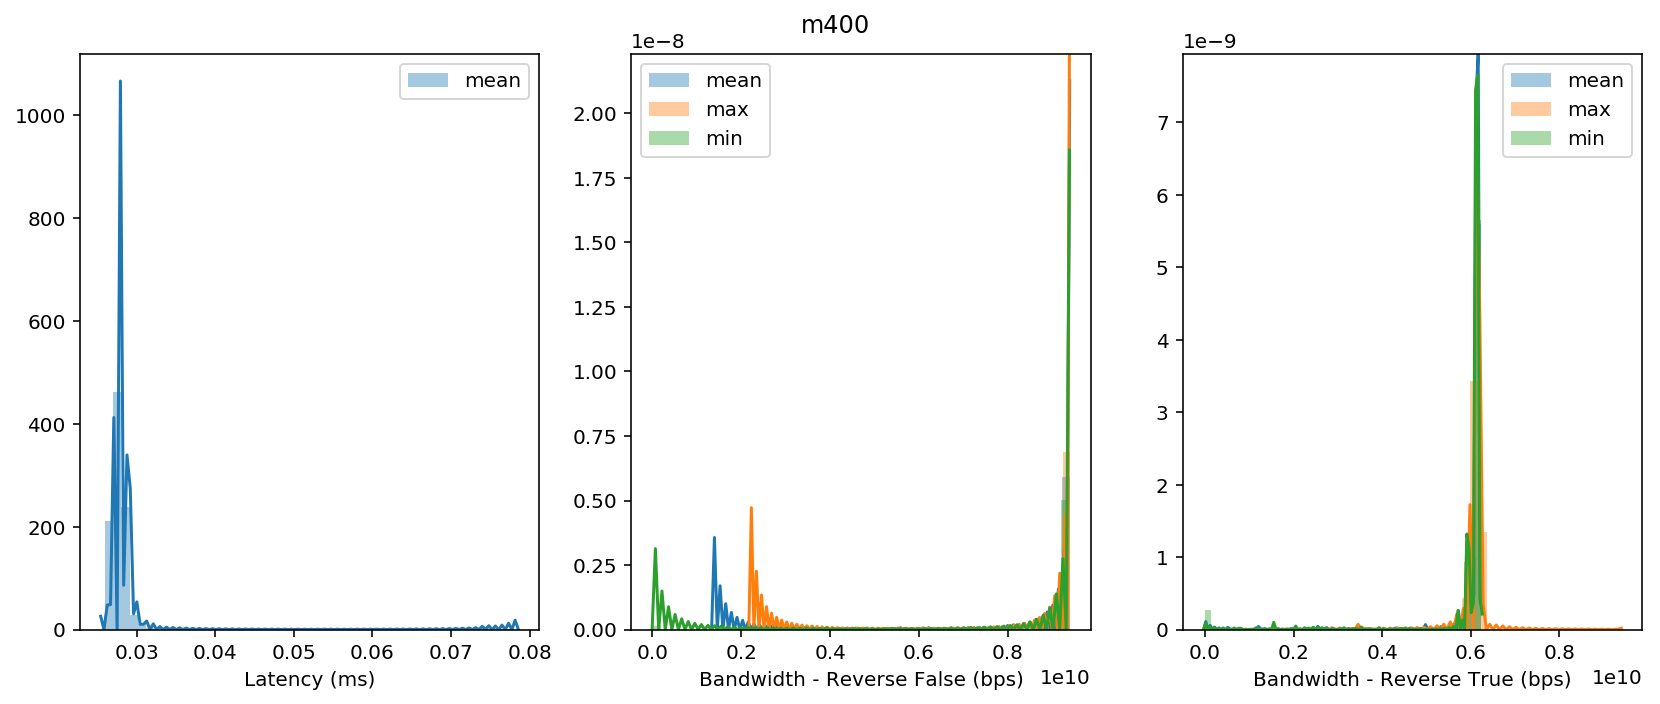

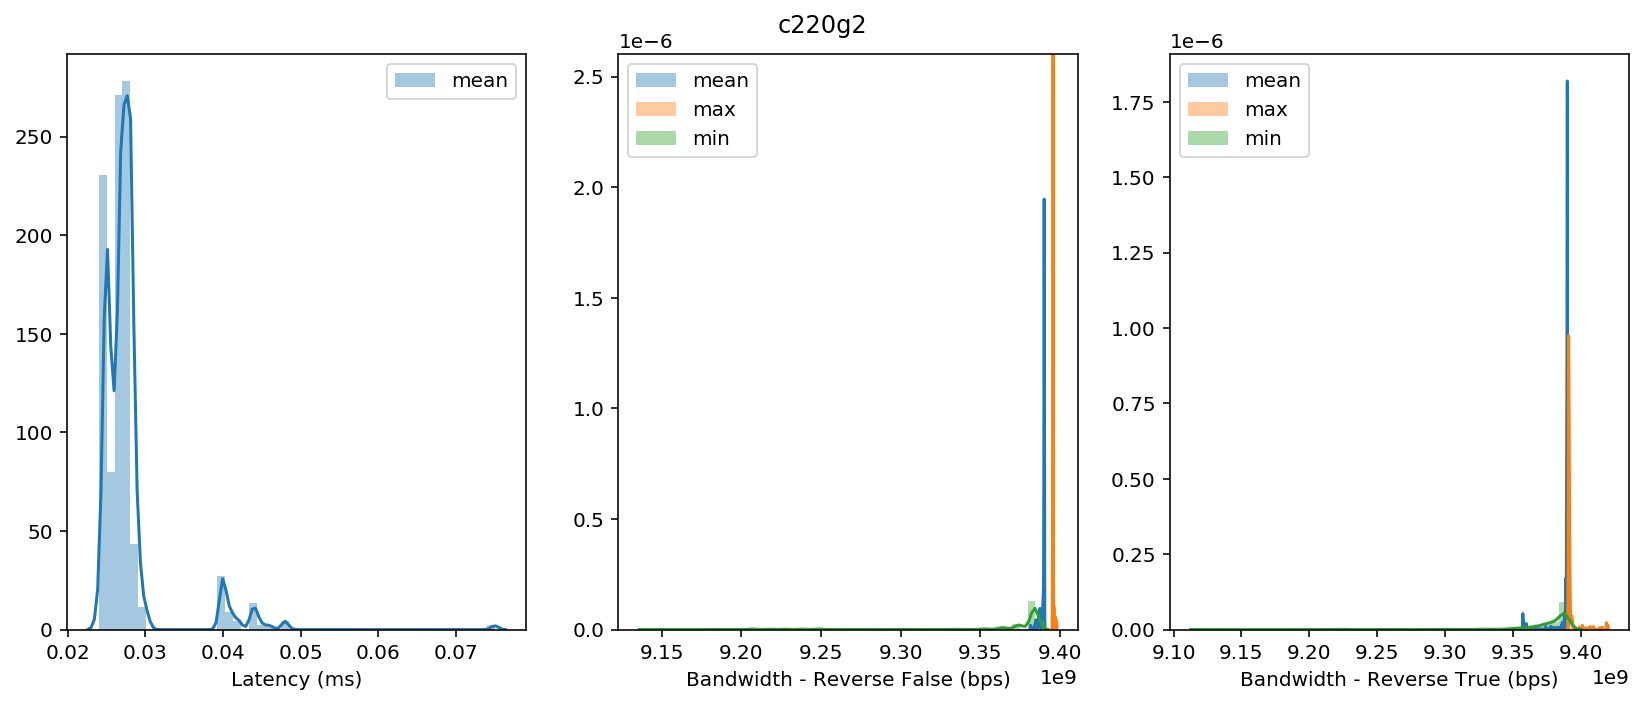

In [10]:
# Breakdown by hw_type, all categories
for hw_type in lat_all["hw_type"].unique():
    f, axarr = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(14, 5))
    plot_df = subset_df(lat_all, {"hw_type": hw_type})
    sns.distplot(plot_df["mean"], ax=axarr[0], label="mean")
    #sns.distplot(plot_df["max"], ax=axarr[0], label="max")
    #sns.distplot(plot_df["min"], ax=axarr[0], label="min")
    axarr[0].set(xlabel="Latency (ms)")
    axarr[0].legend()
    for reverse in bw_all["reverse"].unique():
        plot_df = subset_df(bw_all, {"hw_type": hw_type, "reverse": reverse})
        idx = int(reverse) + 1
        sns.distplot(plot_df["mean"], ax=axarr[idx], label="mean")
        sns.distplot(plot_df["max"], ax=axarr[idx], label="max")
        sns.distplot(plot_df["min"], ax=axarr[idx], label="min")
        axarr[idx].set(xlabel="Bandwidth - Reverse " + str(bool(reverse)) + " (bps)")
        axarr[idx].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        axarr[idx].legend()
    f.suptitle(hw_type)
    f.subplots_adjust(top=.925)
    plot_show_and_save(f, show_only=True)

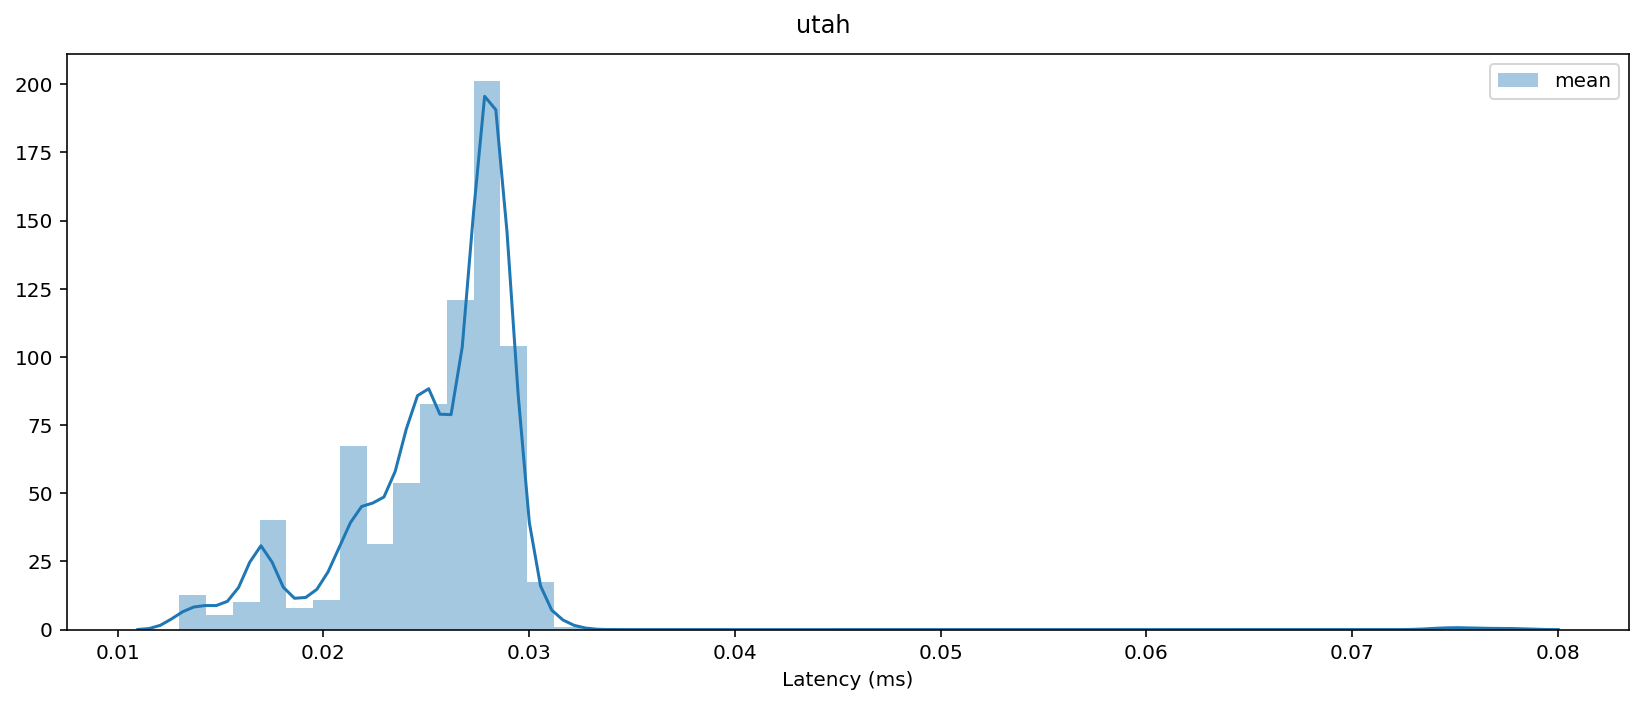

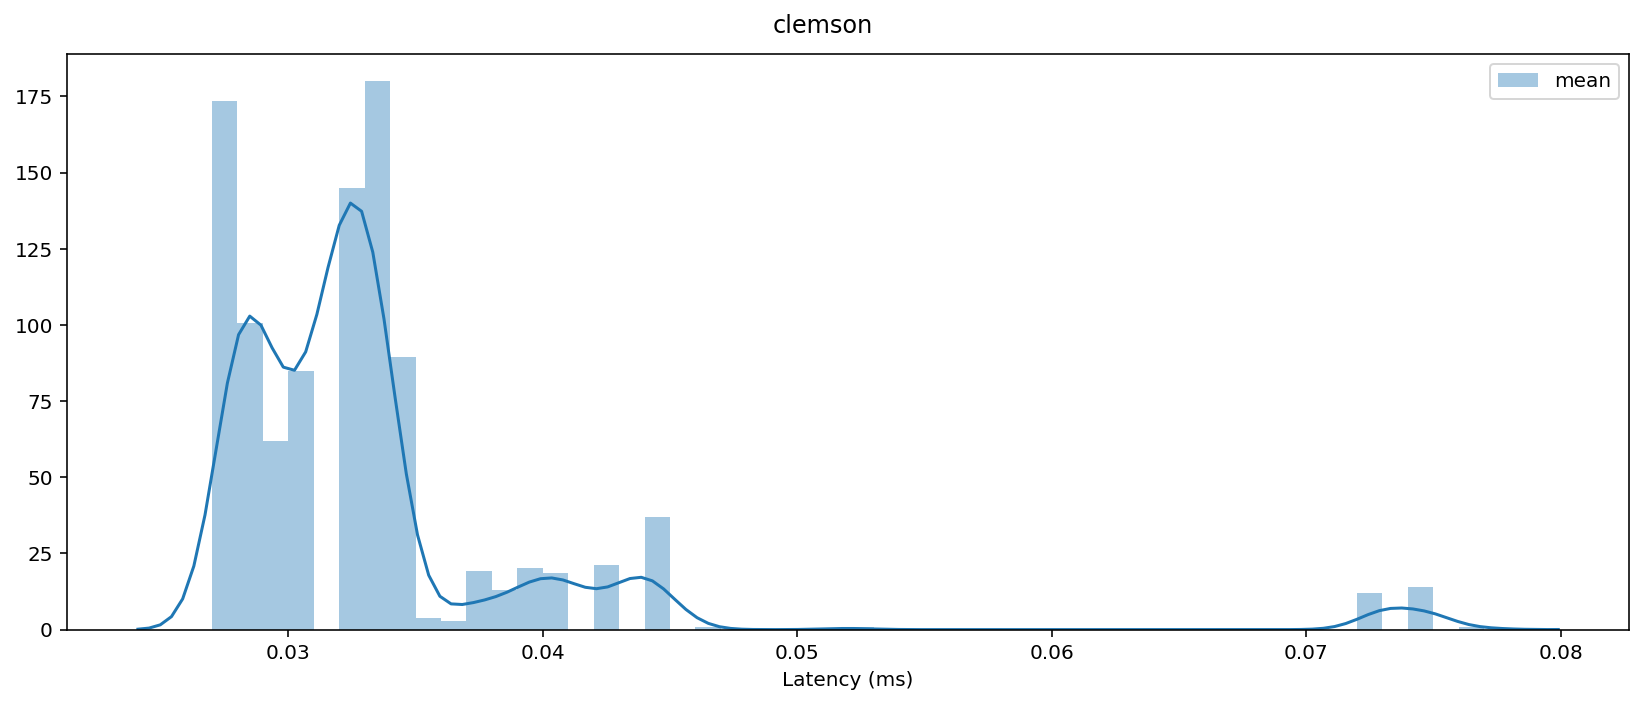

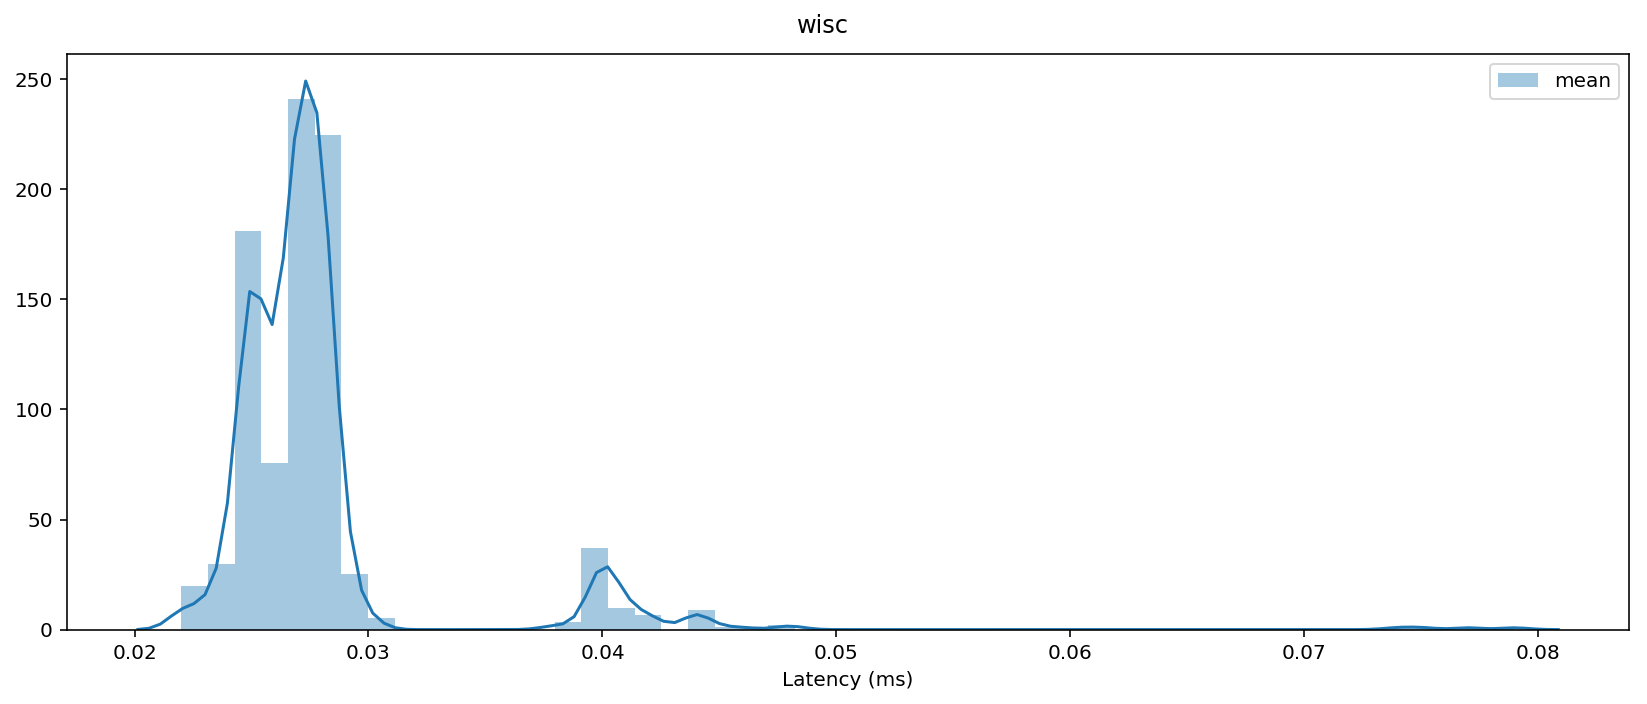

In [11]:
# Breakdown by site, latency only
for site in lat_all["site"].unique():
    f, axarr = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(14, 5))
    plot_df = subset_df(lat_all, {"site": site})
    sns.distplot(plot_df["mean"], ax=axarr, label="mean")
    axarr.set(xlabel="Latency (ms)")
    axarr.legend()
    f.suptitle(site)
    f.subplots_adjust(top=.925)
    plot_show_and_save(f, show_only=True)

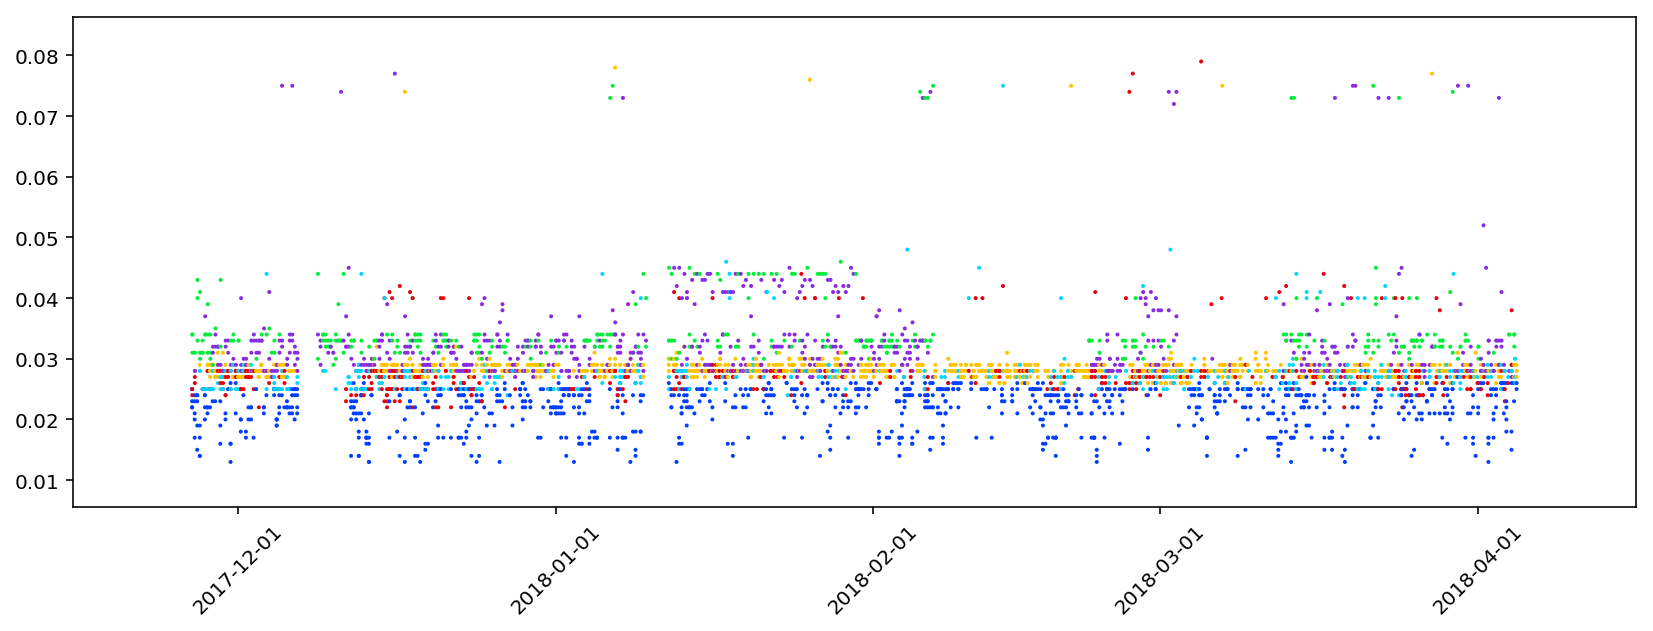

In [12]:
# Using the created color map, visualize all disk measurements on a timeline 
cmap = get_cmap(lat_all, "hw_type")
point_colors = lat_all["hw_type"].map(cmap)

fig, ax = plt.subplots(figsize=(14, 5))
ax.scatter([dt.datetime.fromtimestamp(ts) for ts in lat_all["timestamp"]], lat_all["mean"], 
           c = point_colors, s=4.0, lw=0.0, label='_nolegend_');

# Formatting for timestamps 
ax.xaxis.set_major_formatter(md.DateFormatter('%Y-%m-%d'));
plt.subplots_adjust(bottom=0.2);
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# Since we don't use "%matplotlib inline" magic, 
# this function from bench-lib/common.py needs to be called to display the produced plot
plot_show_and_save(fig, show_only=True)

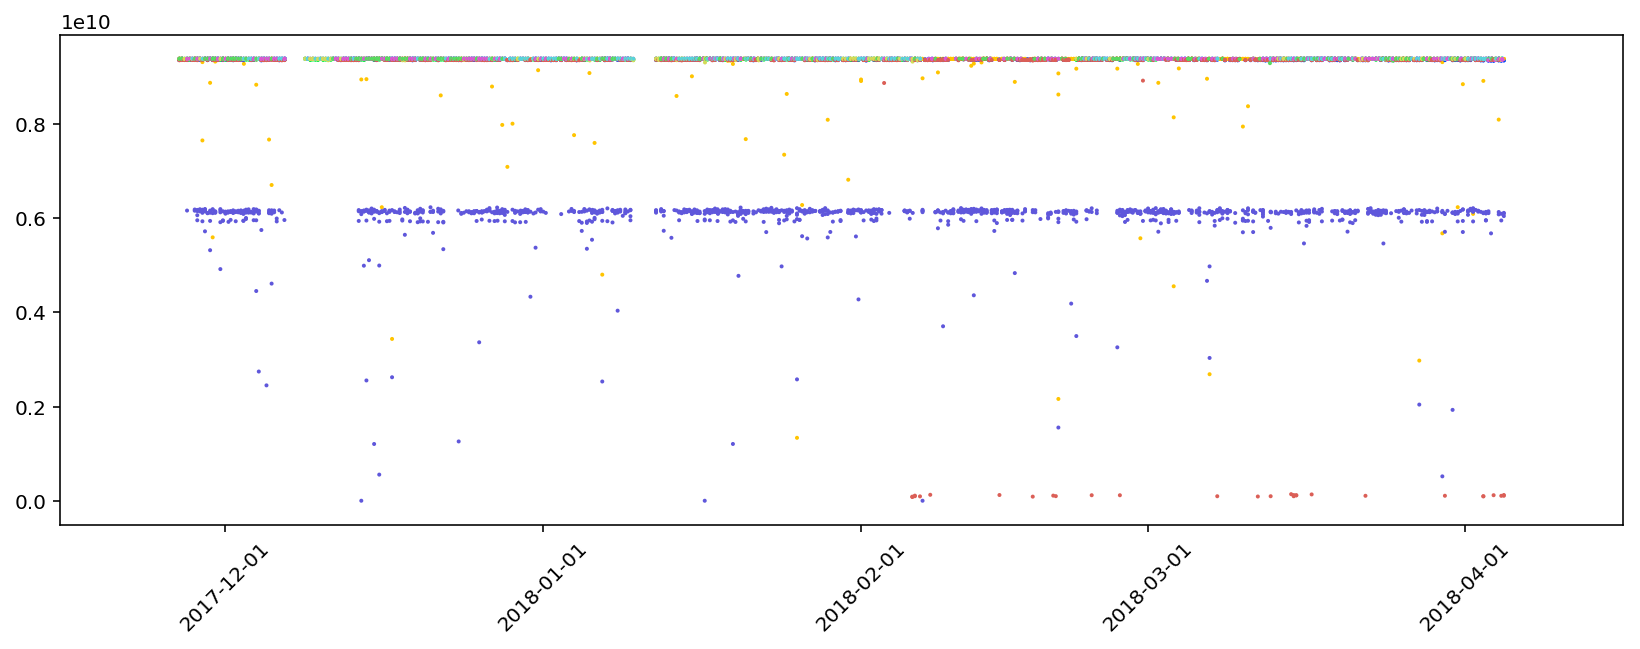

In [13]:
# Using the created color map, visualize all disk measurements on a timeline 
fig, ax = plt.subplots(figsize=(14, 5))
plot_df = subset_df(bw_all, {"reverse":0})
cmap = get_cmap(plot_df, "hw_type")
point_colors = plot_df["hw_type"].map(cmap)
ax.scatter([dt.datetime.fromtimestamp(ts) for ts in plot_df["timestamp"]], plot_df["mean"], 
           c = point_colors, s=4.0, lw=0.0, label='_nolegend_');

plot_df = subset_df(bw_all, {"reverse":1})
cmap = get_cmap(plot_df, "hw_type", palette="hls")
point_colors = plot_df["hw_type"].map(cmap)
ax.scatter([dt.datetime.fromtimestamp(ts) for ts in plot_df["timestamp"]], plot_df["mean"], 
           c = point_colors, s=4.0, lw=0.0, label='_nolegend_');

# Formatting for timestamps 
ax.xaxis.set_major_formatter(md.DateFormatter('%Y-%m-%d'));
plt.subplots_adjust(bottom=0.2);
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# Since we don't use "%matplotlib inline" magic, 
# this function from bench-lib/common.py needs to be called to display the produced plot
plot_show_and_save(fig, show_only=True)

In [14]:
# Switchpaths, filter all that have NaN
def isstr(switch_path):
    return isinstance(switch_path, basestring)

lat_sp_all = pd.merge(lat_all, db['network_info'])
lat_sp_all = lat_sp_all[lat_sp_all['switch_path'].apply(isstr)]


print "Switch Paths:"
common_paths = {}
for site in lat_sp_all['site'].unique():
    site_df = subset_df(lat_sp_all, {'site':site})
    paths = site_df['switch_path'].unique()
    split_paths = []
    for path in paths:
        split_paths.append(path.replace(':',' ').split())
    print site,':'
    #print split_paths
    result = set(split_paths[0])
    for s in split_paths[1:]:
        result.intersection_update(s)
    print '\t',result
    common_paths[site] = result

Switch Paths:
clemson :
	set(['h-itc-cf34-d9100-010', 'h-itc-cf32-d9100-013', 'h-itc-cf36-d6000-005', 'h-itc-cf34-d9100-001'])
wisc :
	set(['cloudlab-leaf-5', 'spinesw-hp5930-A10-42'])
utah :
	set(['bighp1', 'ms-chassis9-switchb'])


In [15]:
lat_sp_all = lat_sp_all.sort_values('timestamp')

clusters = {}
for site in lat_sp_all['site'].unique():
    site_df = subset_df(lat_sp_all, {'site':site})
    #print site
    cluster_idx = 0
    for index, row in site_df.iterrows():
        if site not in clusters:
            clusters[site] = [[row]]
        else:
            if row['timestamp'] - clusters[site][cluster_idx][-1]['timestamp'] > 900:
                clusters[site].append([row])
                cluster_idx += 1
            else:
                clusters[site][cluster_idx].append(row)
        #print row['timestamp']
    #print clusters[site]
    #print '\n'
for site in lat_sp_all['site'].unique():
    print site
    for cluster in clusters[site]:
        if len(cluster) > 1:
            print "Cluster (size " + str(len(cluster)) + "):  " + str(cluster[-1]['timestamp'] - cluster[0]['timestamp']) + " seconds"
        else:
            print "Cluster (size 1)"
        for row in cluster:
            split_path = row['switch_path'].replace(':',' ').split()
            filtered_path = set(split_path)
            filtered_path.difference_update(common_paths[site])
            print row['nodeid'], len(filtered_path), filtered_path
        print '\n'

clemson
Cluster (size 3):  60 seconds
clnode135 2 set(['h-itc-cf31-d6000-016', 'h-itc-cf37-d6000-002'])
clnode035 1 set(['h-itc-cf37-d6000-002'])
clnode133 2 set(['h-itc-cf31-d6000-016', 'h-itc-cf37-d6000-002'])


Cluster (size 3):  3 seconds
clnode090 1 set(['h-itc-cf37-d6000-002'])
clnode017 1 set(['h-itc-cf37-d6000-002'])
clnode009 1 set(['h-itc-cf37-d6000-002'])


Cluster (size 3):  64 seconds
clnode146 1 set(['h-itc-cf31-d6000-016'])
clnode166 1 set(['h-itc-cf31-d6000-016'])
clnode163 1 set(['h-itc-cf31-d6000-016'])


Cluster (size 3):  64 seconds
clnode103 0 set([])
clnode131 0 set([])
clnode138 1 set(['h-itc-cf31-d6000-016'])


Cluster (size 3):  19 seconds
clnode016 1 set(['h-itc-cf37-d6000-002'])
clnode114 0 set([])
clnode113 0 set([])


Cluster (size 3):  71 seconds
clnode014 1 set(['h-itc-cf37-d6000-002'])
clnode109 0 set([])
clnode116 1 set(['h-itc-cf37-d6000-002'])


Cluster (size 3):  15 seconds
clnode100 0 set([])
clnode132 0 set([])
clnode034 1 set(['h-itc-cf37-d6000-00

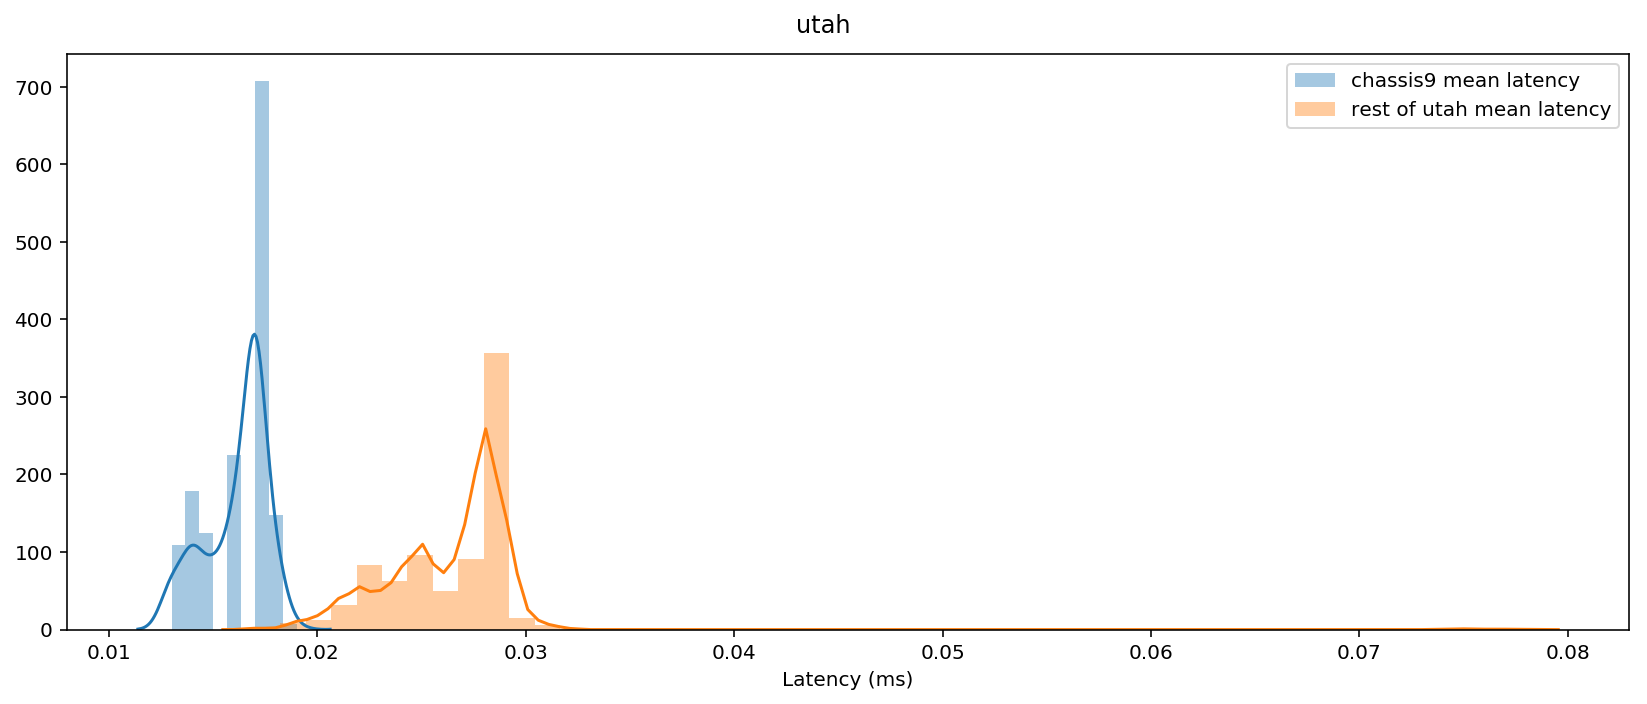

/notebooks/output/utah_lat_locality.pdf

In [16]:
site = 'utah'
f, axarr = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(14, 5))
site_df = subset_df(lat_all, {"site": site})
plot_df = site_df[site_df['nodeid'].apply(is_local_utah)]
sns.distplot(plot_df["mean"], ax=axarr, label="chassis9 mean latency")
plot_df = site_df[site_df['nodeid'].apply(is_not_local_utah)]
sns.distplot(plot_df["mean"], ax=axarr, label="rest of utah mean latency")
axarr.set(xlabel="Latency (ms)")
axarr.legend()
f.suptitle(site)
f.subplots_adjust(top=.925)
plot_show_and_save(f, "utah_lat_locality.pdf", dest_dir)

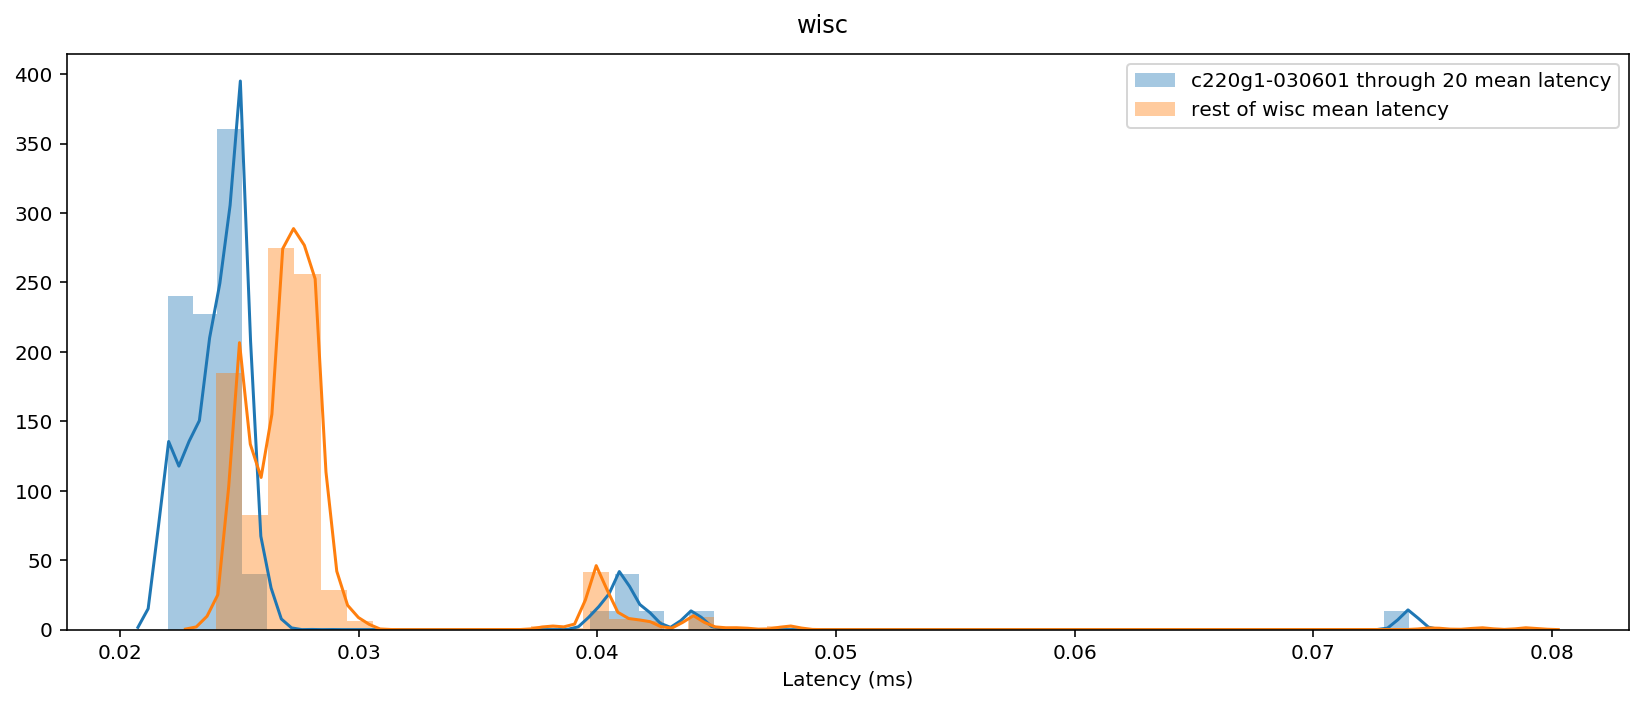

/notebooks/output/wisc_lat_locality.pdf

In [17]:
site = 'wisc'
f, axarr = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(14, 5))
site_df = subset_df(lat_all, {"site": site})
plot_df = site_df[site_df['nodeid'].apply(is_local_wisc)]
sns.distplot(plot_df["mean"], ax=axarr, label="c220g1-030601 through 20 mean latency")
plot_df = site_df[site_df['nodeid'].apply(is_not_local_wisc)]
sns.distplot(plot_df["mean"], ax=axarr, label="rest of wisc mean latency")
axarr.set(xlabel="Latency (ms)")
axarr.legend()
f.suptitle(site)
f.subplots_adjust(top=.925)
plot_show_and_save(f, "wisc_lat_locality.pdf", dest_dir)

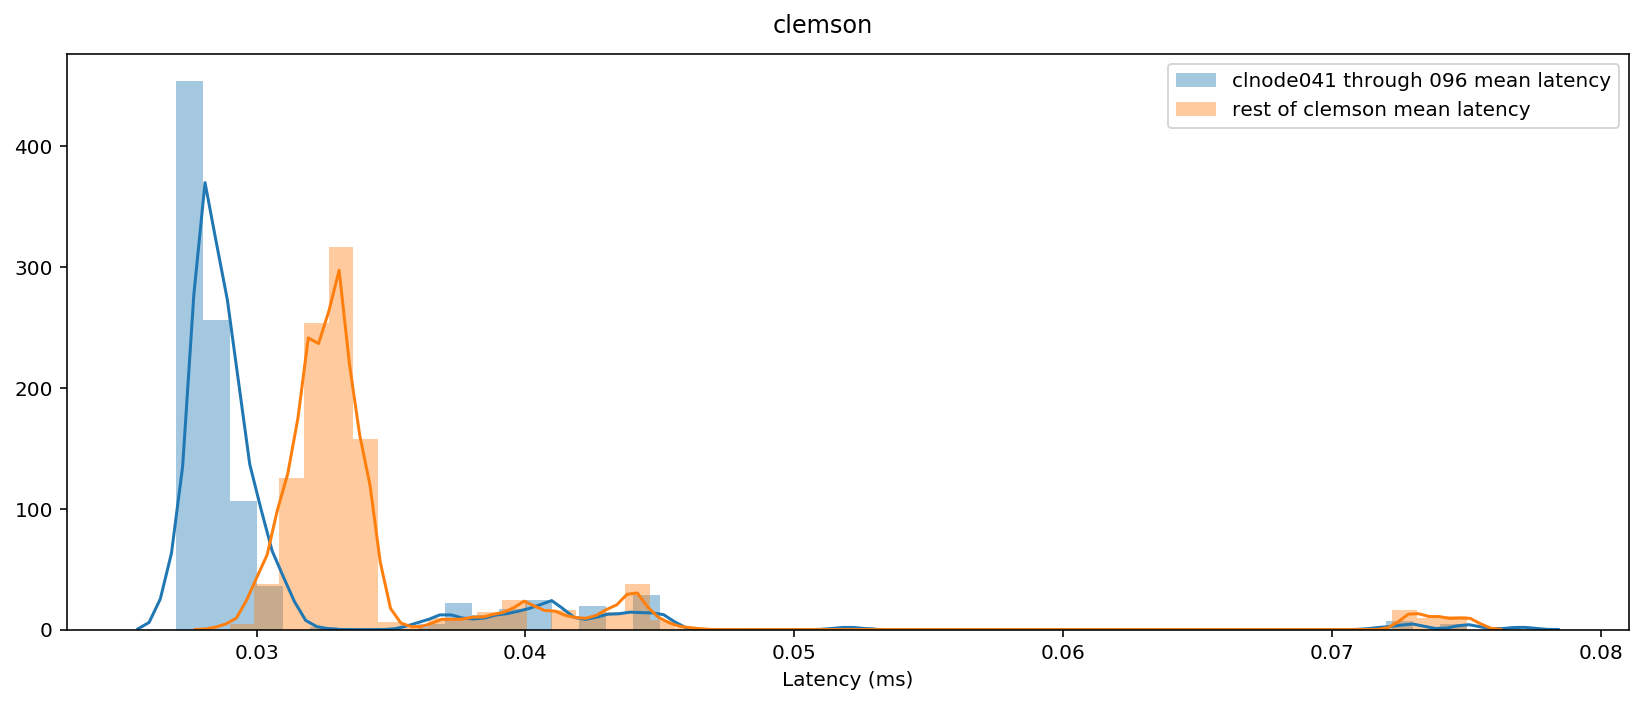

/notebooks/output/clemson_lat_locality.pdf

In [18]:
site = 'clemson'
f, axarr = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(14, 5))
site_df = subset_df(lat_all, {"site": site})
plot_df = site_df[site_df['nodeid'].apply(is_local_clemson)]
sns.distplot(plot_df["mean"], ax=axarr, label="clnode041 through 096 mean latency")
plot_df = site_df[site_df['nodeid'].apply(is_not_local_clemson)]
sns.distplot(plot_df["mean"], ax=axarr, label="rest of clemson mean latency")
axarr.set(xlabel="Latency (ms)")
axarr.legend()
f.suptitle(site)
f.subplots_adjust(top=.925)
plot_show_and_save(f, "clemson_lat_locality.pdf", dest_dir)

In [19]:
# Print packet loss stats
for site in lat_all["site"].unique():
    site_df = subset_df(lat_all, {"site":site})
    total_runs = len(site_df)
    site_df = site_df[site_df["packet_loss"] != "0%"]
    print site + " packet-loss:"
    if len(site_df) > 0:
        print "\tNon-zero packet-loss on",len(site_df),"/",total_runs,"runs"
        print "\t",float(len(site_df))*100/total_runs,"%"
        for row in site_df['timestamp'].unique():
            print "\t\tPacket loss on",dt.datetime.fromtimestamp(row)
        display(site_df.T)
    else:
        print "\tNone"

utah packet-loss:
	Non-zero packet-loss on 8 / 2233 runs
	0.358262427228 %
		Packet loss on 2017-12-04 13:07:16
		Packet loss on 2017-12-14 07:07:46
		Packet loss on 2017-12-14 13:07:06
		Packet loss on 2017-12-22 07:06:44
		Packet loss on 2018-01-09 13:17:10
		Packet loss on 2018-01-25 19:14:43
		Packet loss on 2018-02-05 19:11:35
		Packet loss on 2018-03-08 07:11:55


320   \
run_uuid              6681bdd1-5266-48c1-bfc0-db5859995ece   
timestamp                                       1512392836   
nodeid                                              ms0716   
nodeuuid              b6846e6a-74c8-11e4-85c8-179a28bd1b8c   
runtime                                             5032ms   
packets_sent                                         10000   
packets_received                                      9613   
packet_loss                                             3%   
max                                                  0.273   
min                                                  0.027   
mean                                                 0.029   
stdev                                                0.008   
ipg                                                  0.503   
ewma                                                 0.028   
units                                                   ms   
gcc_ver                                              5.4.0   
version_hash      08a0bec44063cdf3c360cd6e41f0aef75a9c9cc6   
total_mem                                            62GiB   
mem_clock_speed                               Unknown(ARM)   
arch                                               aarch64   
run_success                                              1   
site                                                  utah   
nthreads                                                 8   
nsockets                                                 1   
hw_type                                               m400   
ping_version                             iputils-s20121221   
ping_count                                           10000   
ping_source_ip                                 192.168.1.1   
ping_dest_ip                                 192.168.1.100   
ping_dest_nodeid                                    ms0914   
ping_size                                               56   
vlan_name                                          vlan289   
vlan_ip                                        192.168.1.1   
vlan_hwaddr                              02:4d:39:38:86:3a   
vlan_driver                            802.1Q VLAN Support   
vlan_driver_ver                                        1.8   
if_name                                           enp1s0d1   
if_hwaddr                                fc:15:b4:1f:1d:33   
if_hwinfo                  MT27520 Family [ConnectX-3 Pro]   
if_speed                                         10000Mb/s   
if_duplex                                             Full   
if_port_type                                          None   
if_driver                                          mlx4_en   
if_driver_ver                             2.2-1 (Feb 2014)   
if_bus_location                               0000:01:00.0   
switch_path                                            NaN   
test                                               latency   
directionality                                     forward   

                                                               558   \
run_uuid                       735472e6-20cb-459e-ab88-030b42cc4fc5   
timestamp                                                1513235266   
nodeid                                                       ms0737   
nodeuuid                       ba81bbf3-74c8-11e4-85c8-179a28bd1b8c   
runtime                                                      5923ms   
packets_sent                                                  10000   
packets_received                                               9538   
packet_loss                                                      4%   
max                                                           0.264   
min                                                           0.025   
mean                                                          0.029   
stdev                                                         0.007   
ipg                                                           0.592   
ewma                 

clemson packet-loss:
	None
wisc packet-loss:
	None


utah :
	Ratio of 0 retransmit runs/total runs:  4065/4466 91.0210479176%
	Average/Median number of retransmits:  230.245857591
	Local nodes:
		Ratio of 0 retransmit runs/total runs:  355/386 91.9689119171%
		Average number of retransmits:  16.6295336788
	Non-local nodes:
		Ratio of 0 retransmit runs/total runs:  3710/4080 90.931372549%
		Average number of retransmits:  250.455637255


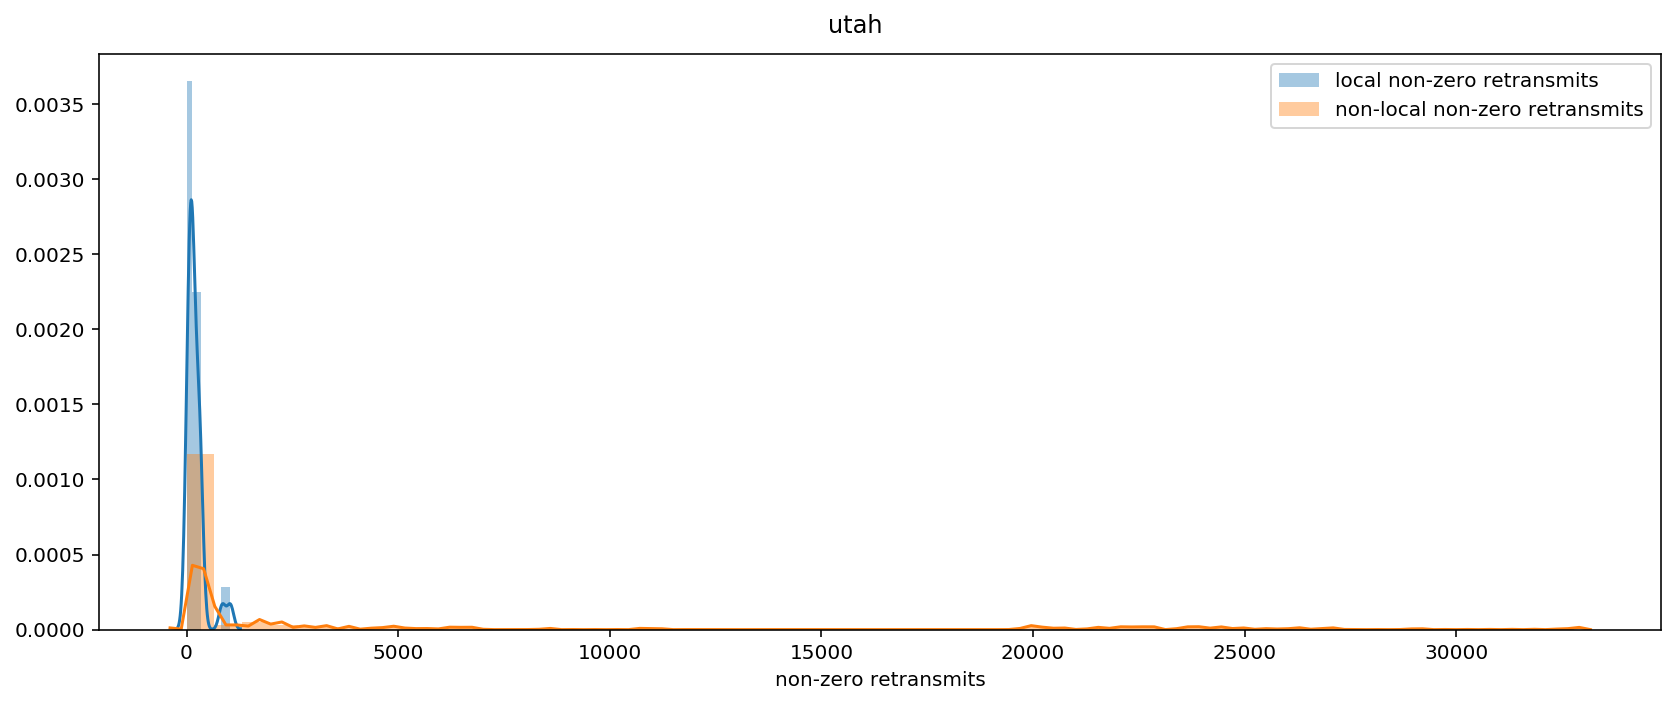

clemson :
	Ratio of 0 retransmit runs/total runs:  1663/2166 76.7774699908%
	Average/Median number of retransmits:  14.6135734072
	Local nodes:
		Ratio of 0 retransmit runs/total runs:  558/828 67.3913043478%
		Average number of retransmits:  8.03623188406
	Non-local nodes:
		Ratio of 0 retransmit runs/total runs:  1105/1338 82.5859491779%
		Average number of retransmits:  18.6838565022


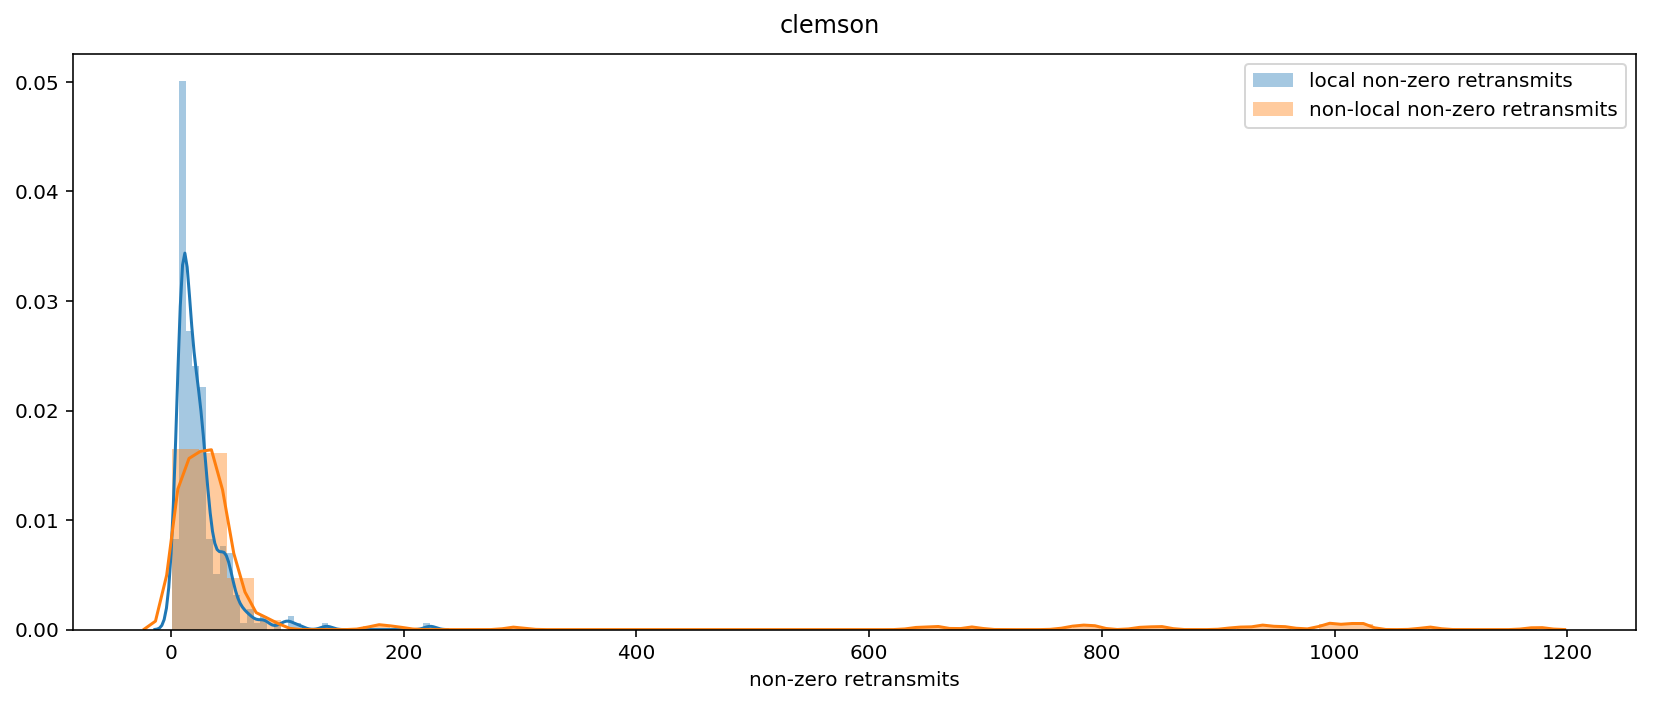

wisc :
	Ratio of 0 retransmit runs/total runs:  909/1600 56.8125%
	Average/Median number of retransmits:  22.048125
	Local nodes:
		Ratio of 0 retransmit runs/total runs:  86/144 59.7222222222%
		Average number of retransmits:  15.9236111111
	Non-local nodes:
		Ratio of 0 retransmit runs/total runs:  823/1456 56.5247252747%
		Average number of retransmits:  22.6538461538


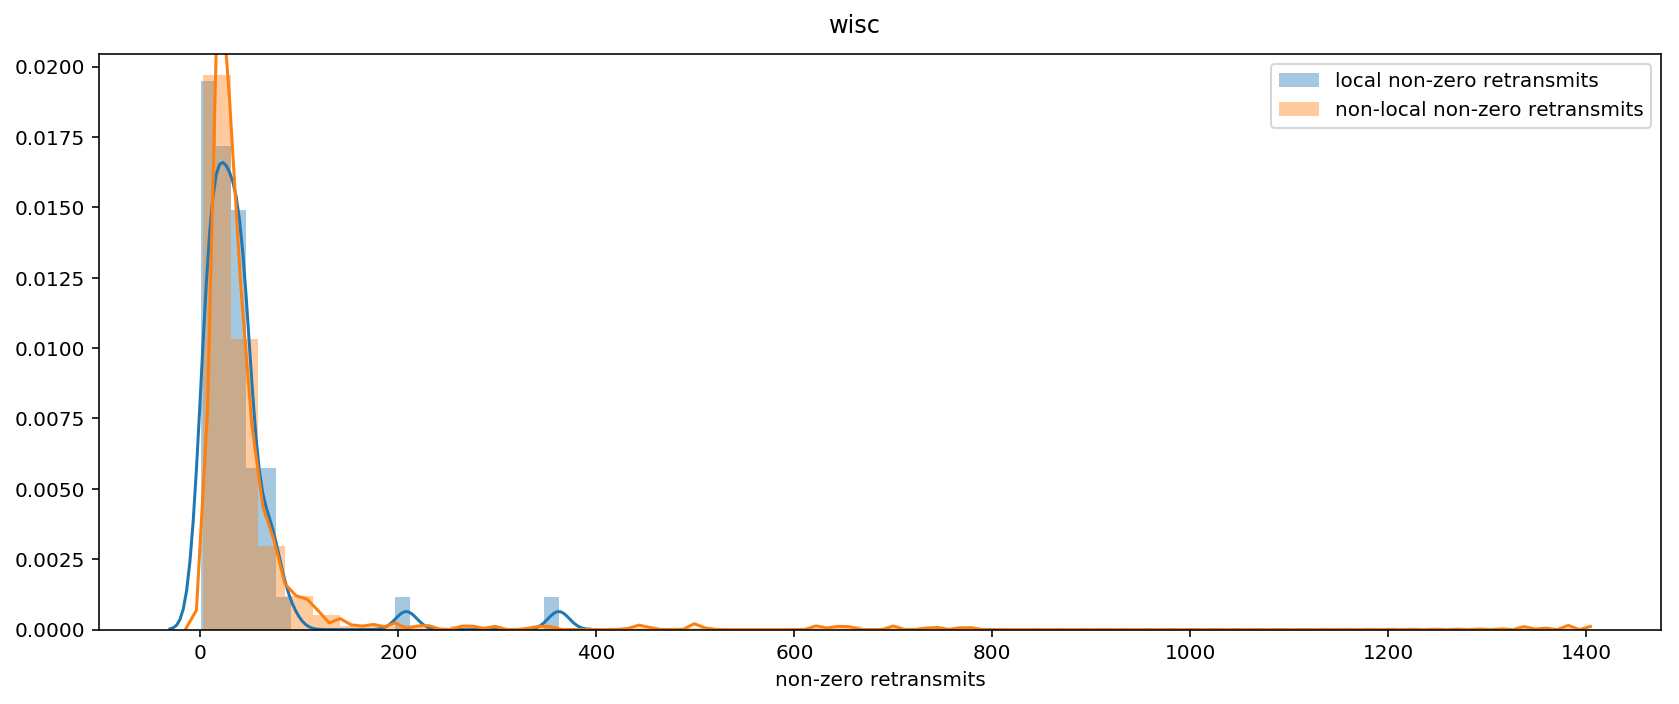

In [20]:
# Retransmits
# Breakdown by site and locality
for site in bw_all["site"].unique():
    f, axarr = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(14, 5))
    site_df = subset_df(bw_all, {"site": site})
    print site,":"
    print "\tRatio of 0 retransmit runs/total runs:  " + \
          str(len(site_df[site_df["retransmits"] == 0])) + "/" + str(len(site_df)) + " " +\
          str(float(len(site_df[site_df["retransmits"] == 0]))*100/len(site_df)) + "%"
    print "\tAverage/Median number of retransmits:  " + str(site_df["retransmits"].mean())
    
    if site == 'utah':
        plot_df = site_df[site_df['nodeid'].apply(is_local_utah)]
    elif site == 'wisc':
        plot_df = site_df[site_df['nodeid'].apply(is_local_wisc)]
    elif site == 'clemson':
        plot_df = site_df[site_df['nodeid'].apply(is_local_clemson)]
    if len(plot_df) > 0:
        print "\tLocal nodes:"
        print "\t\tRatio of 0 retransmit runs/total runs:  " + \
              str(len(plot_df[plot_df["retransmits"] == 0])) + "/" + str(len(plot_df)) + " " + \
              str(float(len(plot_df[plot_df["retransmits"] == 0]))*100/len(plot_df)) + "%"
        print "\t\tAverage number of retransmits:  " + str(plot_df["retransmits"].mean())
        plot_df = plot_df[plot_df["retransmits"] > 0]
        if len(plot_df) > 0:
            sns.distplot(plot_df["retransmits"], ax=axarr, label="local non-zero retransmits")
    
    if site == 'utah':
        plot_df = site_df[site_df['nodeid'].apply(is_not_local_utah)]
    elif site == 'wisc':
        plot_df = site_df[site_df['nodeid'].apply(is_not_local_wisc)]
    elif site == 'clemson':
        plot_df = site_df[site_df['nodeid'].apply(is_not_local_clemson)]
    if len(plot_df) > 0:
        print "\tNon-local nodes:"
        print "\t\tRatio of 0 retransmit runs/total runs:  " + \
              str(len(plot_df[plot_df["retransmits"] == 0])) + "/" + str(len(plot_df)) + " " + \
              str(float(len(plot_df[plot_df["retransmits"] == 0]))*100/len(plot_df)) + "%"
        print "\t\tAverage number of retransmits:  " + str(plot_df["retransmits"].mean())
        plot_df = plot_df[plot_df["retransmits"] > 0]
        if len(plot_df) > 0:
            sns.distplot(plot_df["retransmits"], ax=axarr, label="non-local non-zero retransmits")
    
    axarr.set(xlabel="non-zero retransmits")
    axarr.legend()
    f.suptitle(site)
    f.subplots_adjust(top=.925)
    plot_show_and_save(f, show_only=True)

m510 :
	Ratio of 0 retransmit runs/total runs:  1843/2040 90.3431372549%
	Average number of retransmits:  359.045588235
	Local nodes:
		Ratio of 0 retransmit runs/total runs:  355/386 91.9689119171%
		Average number of retransmits:  16.6295336788
	Non-local nodes:
		Ratio of 0 retransmit runs/total runs:  1488/1654 89.9637243047%
		Average number of retransmits:  438.956469166


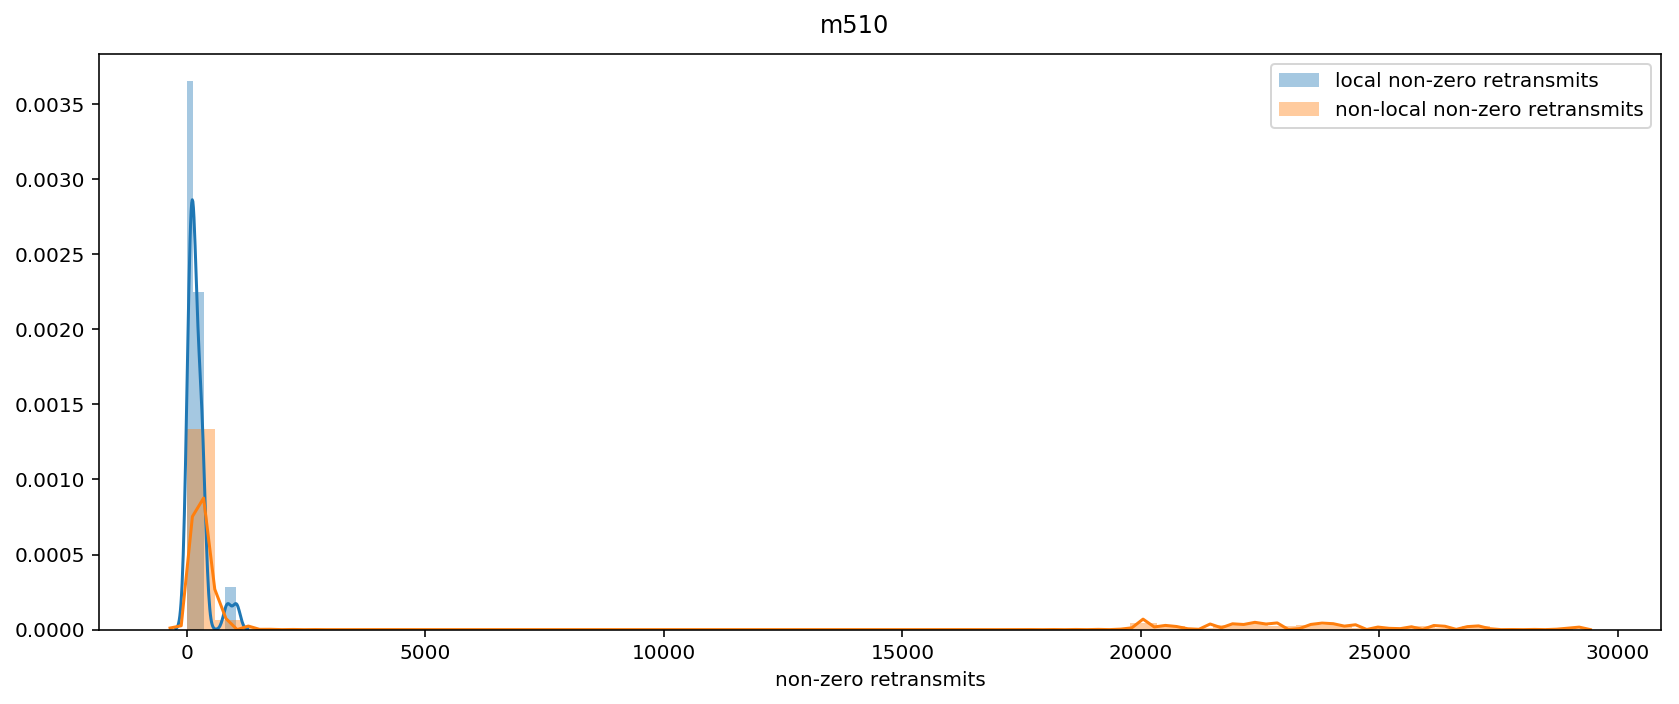

c6320 :
	Ratio of 0 retransmit runs/total runs:  522/754 69.2307692308%
	Average number of retransmits:  32.9151193634
	Non-local nodes:
		Ratio of 0 retransmit runs/total runs:  522/754 69.2307692308%
		Average number of retransmits:  32.9151193634


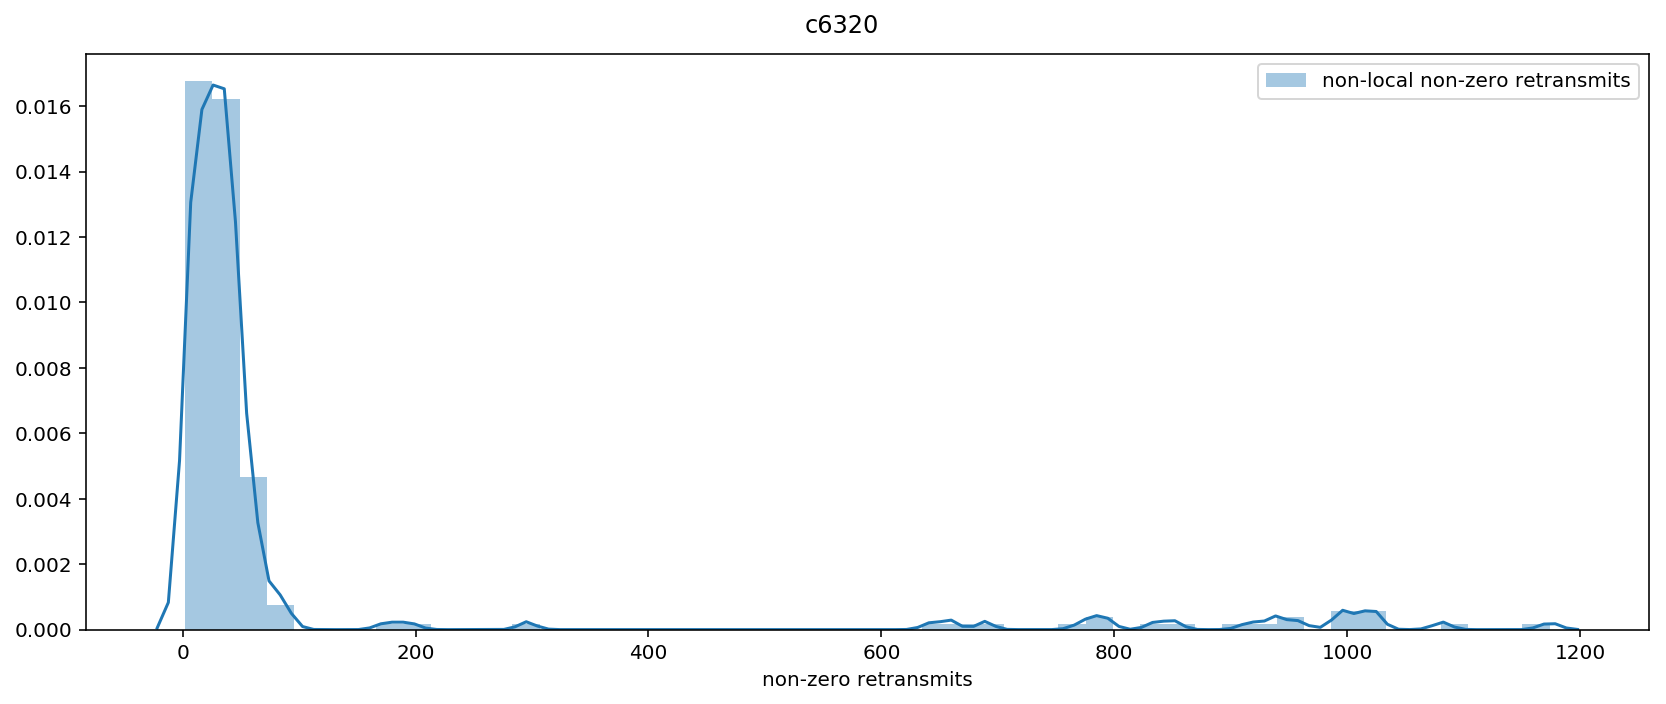

c220g1 :
	Ratio of 0 retransmit runs/total runs:  411/740 55.5405405405%
	Average number of retransmits:  19.8594594595
	Local nodes:
		Ratio of 0 retransmit runs/total runs:  86/144 59.7222222222%
		Average number of retransmits:  15.9236111111
	Non-local nodes:
		Ratio of 0 retransmit runs/total runs:  325/596 54.5302013423%
		Average number of retransmits:  20.8104026846


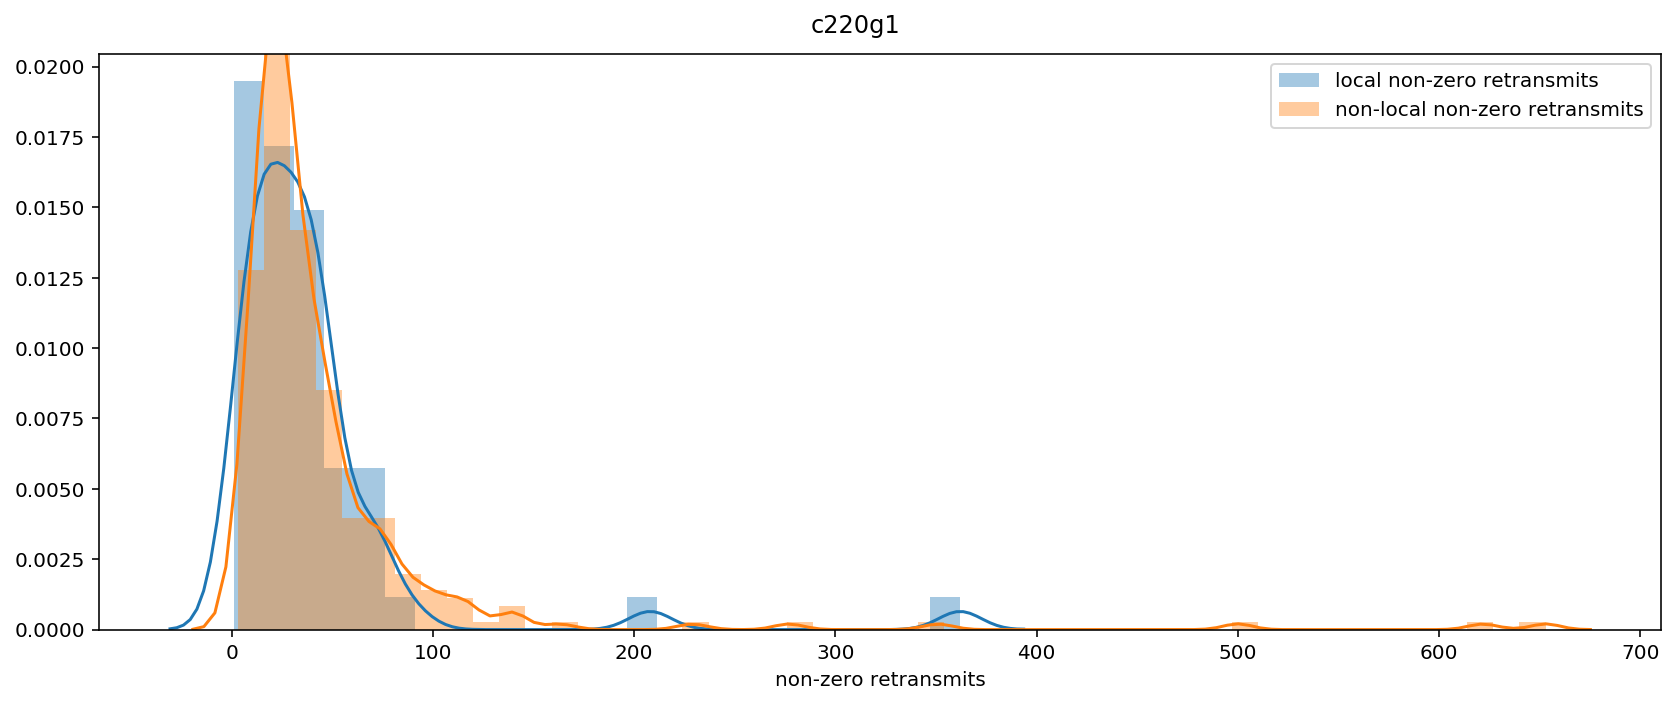

c8220 :
	Ratio of 0 retransmit runs/total runs:  1141/1412 80.8073654391%
	Average number of retransmits:  4.84065155807
	Local nodes:
		Ratio of 0 retransmit runs/total runs:  558/828 67.3913043478%
		Average number of retransmits:  8.03623188406
	Non-local nodes:
		Ratio of 0 retransmit runs/total runs:  583/584 99.8287671233%
		Average number of retransmits:  0.309931506849


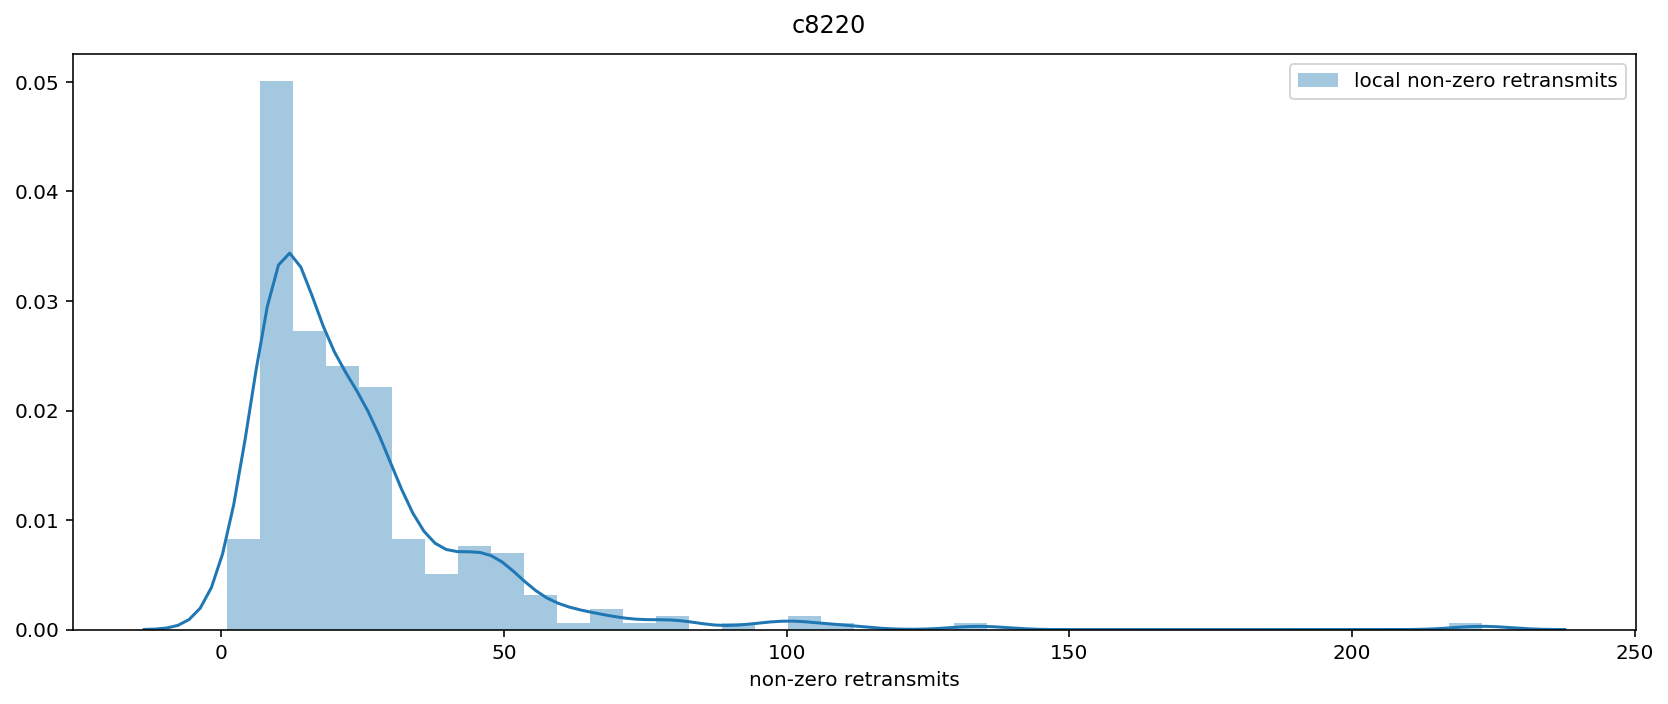

m400 :
	Ratio of 0 retransmit runs/total runs:  2222/2426 91.5910964551%
	Average number of retransmits:  121.93940643
	Non-local nodes:
		Ratio of 0 retransmit runs/total runs:  2222/2426 91.5910964551%
		Average number of retransmits:  121.93940643


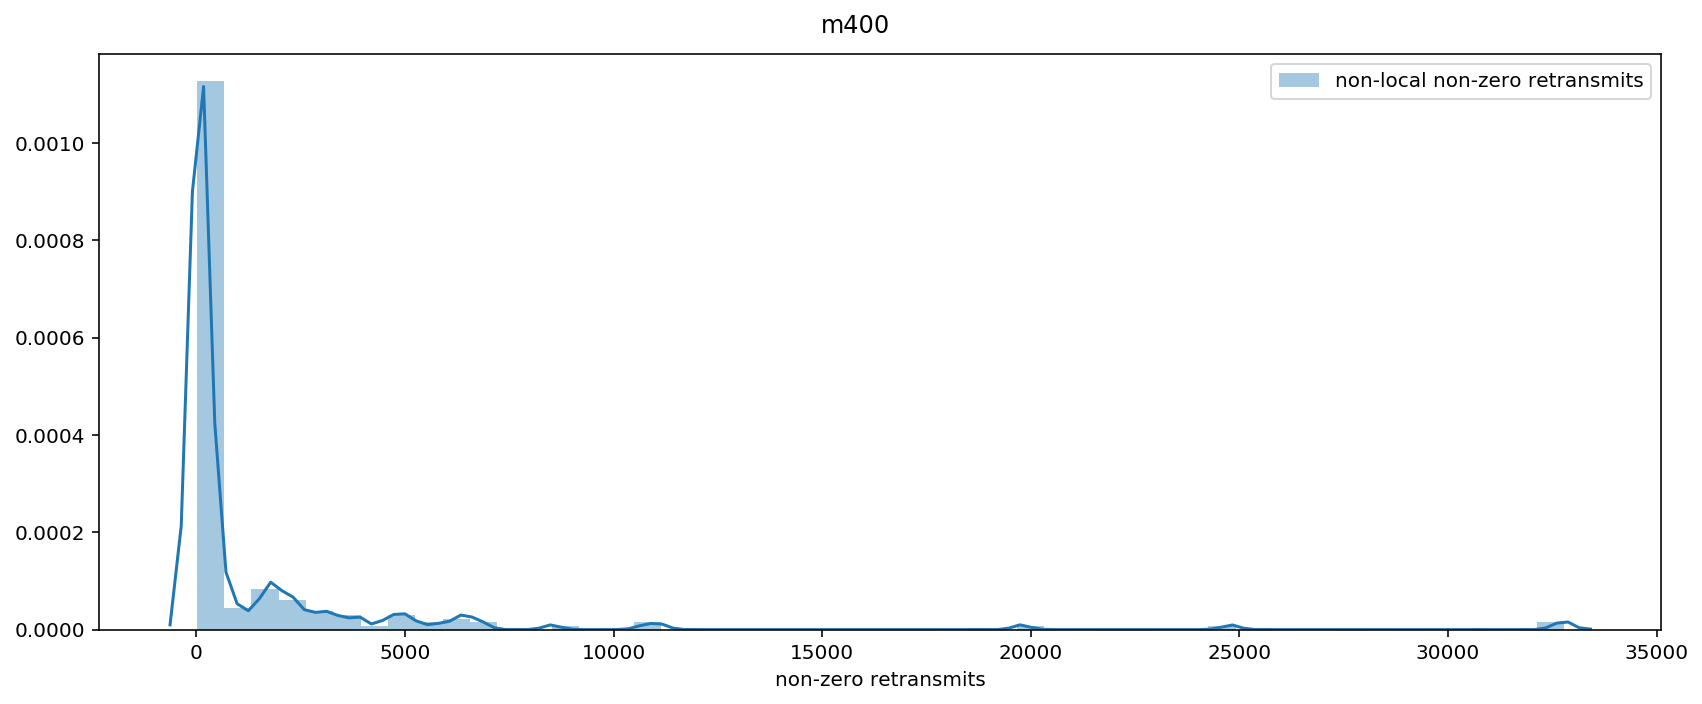

c220g2 :
	Ratio of 0 retransmit runs/total runs:  498/860 57.9069767442%
	Average number of retransmits:  23.9313953488
	Non-local nodes:
		Ratio of 0 retransmit runs/total runs:  498/860 57.9069767442%
		Average number of retransmits:  23.9313953488


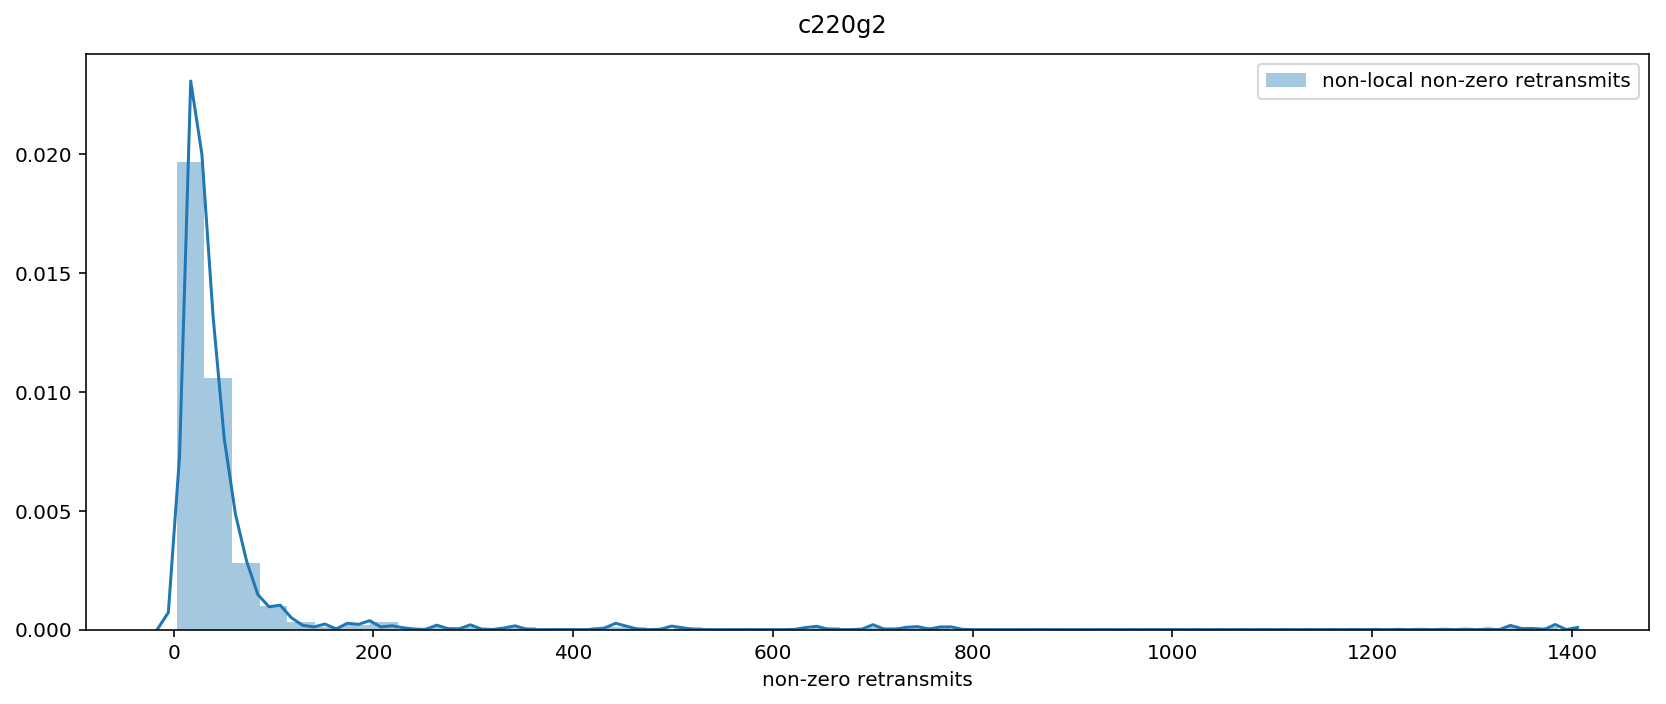

In [21]:
# Retransmits
# Breakdown by hw_type and locality
for hw_type in bw_all["hw_type"].unique():
    f, axarr = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(14, 5))
    site_df = subset_df(bw_all, {"hw_type": hw_type})
    site = site_df["site"].unique()[0]
    print hw_type,":"
    print "\tRatio of 0 retransmit runs/total runs:  " + \
          str(len(site_df[site_df["retransmits"] == 0])) + "/" + str(len(site_df)) + " " + \
          str(float(len(site_df[site_df["retransmits"] == 0]))*100/len(site_df)) + "%"
    print "\tAverage number of retransmits:  " + str(site_df["retransmits"].mean())
    
    if site == 'utah':
        plot_df = site_df[site_df['nodeid'].apply(is_local_utah)]
    elif site == 'wisc':
        plot_df = site_df[site_df['nodeid'].apply(is_local_wisc)]
    elif site == 'clemson':
        plot_df = site_df[site_df['nodeid'].apply(is_local_clemson)]
    if len(plot_df) > 0:
        print "\tLocal nodes:"
        print "\t\tRatio of 0 retransmit runs/total runs:  " + \
              str(len(plot_df[plot_df["retransmits"] == 0])) + "/" + str(len(plot_df)) + " " + \
              str(float(len(plot_df[plot_df["retransmits"] == 0]))*100/len(plot_df)) + "%"
        print "\t\tAverage number of retransmits:  " + str(plot_df["retransmits"].mean())
        #print plot_df["nodeid"].unique()
        plot_df = plot_df[plot_df["retransmits"] > 0]
        if len(plot_df) > 0:
            sns.distplot(plot_df["retransmits"], ax=axarr, label="local non-zero retransmits")
    
    if site == 'utah':
        plot_df = site_df[site_df['nodeid'].apply(is_not_local_utah)]
    elif site == 'wisc':
        plot_df = site_df[site_df['nodeid'].apply(is_not_local_wisc)]
    elif site == 'clemson':
        plot_df = site_df[site_df['nodeid'].apply(is_not_local_clemson)]
    if len(plot_df) > 0:
        print "\tNon-local nodes:"
        print "\t\tRatio of 0 retransmit runs/total runs:  " + \
              str(len(plot_df[plot_df["retransmits"] == 0])) + "/" + str(len(plot_df)) + " " + \
              str(float(len(plot_df[plot_df["retransmits"] == 0]))*100/len(plot_df)) + "%"
        print "\t\tAverage number of retransmits:  " + str(plot_df["retransmits"].mean())
        #print plot_df["nodeid"].unique()
        plot_df = plot_df[plot_df["retransmits"] > 1]
        if len(plot_df) > 1:
            sns.distplot(plot_df["retransmits"], ax=axarr, label="non-local non-zero retransmits")
    
    axarr.set(xlabel="non-zero retransmits")
    axarr.legend()
    f.suptitle(hw_type)
    f.subplots_adjust(top=.925)
    plot_show_and_save(f, show_only=True)

m510 :
	Ratio of 0 retransmit runs/total runs:  1843/2040 90.3431372549%
	Average number of retransmits:  359.045588235

	Local nodes:
		Ratio of 0 retransmit runs/total runs:  355/386 91.9689119171%
		Average number of retransmits:  16.6295336788

		Forwards runs:
			Ratio of 0 retransmit runs/total runs:  171/193 88.6010362694%
			Average number of retransmits:  23.2383419689

		Reversed runs:
			Ratio of 0 retransmit runs/total runs:  184/193 95.3367875648%
			Average number of retransmits:  10.0207253886

	Non-local nodes:
		Ratio of 0 retransmit runs/total runs:  1488/1654 89.9637243047%
		Average number of retransmits:  438.956469166

		Forwards runs:
			Ratio of 0 retransmit runs/total runs:  763/827 92.261185006%
			Average number of retransmits:  18.6396614268

		Reversed runs:
			Ratio of 0 retransmit runs/total runs:  725/827 87.6662636034%
			Average number of retransmits:  859.273276904



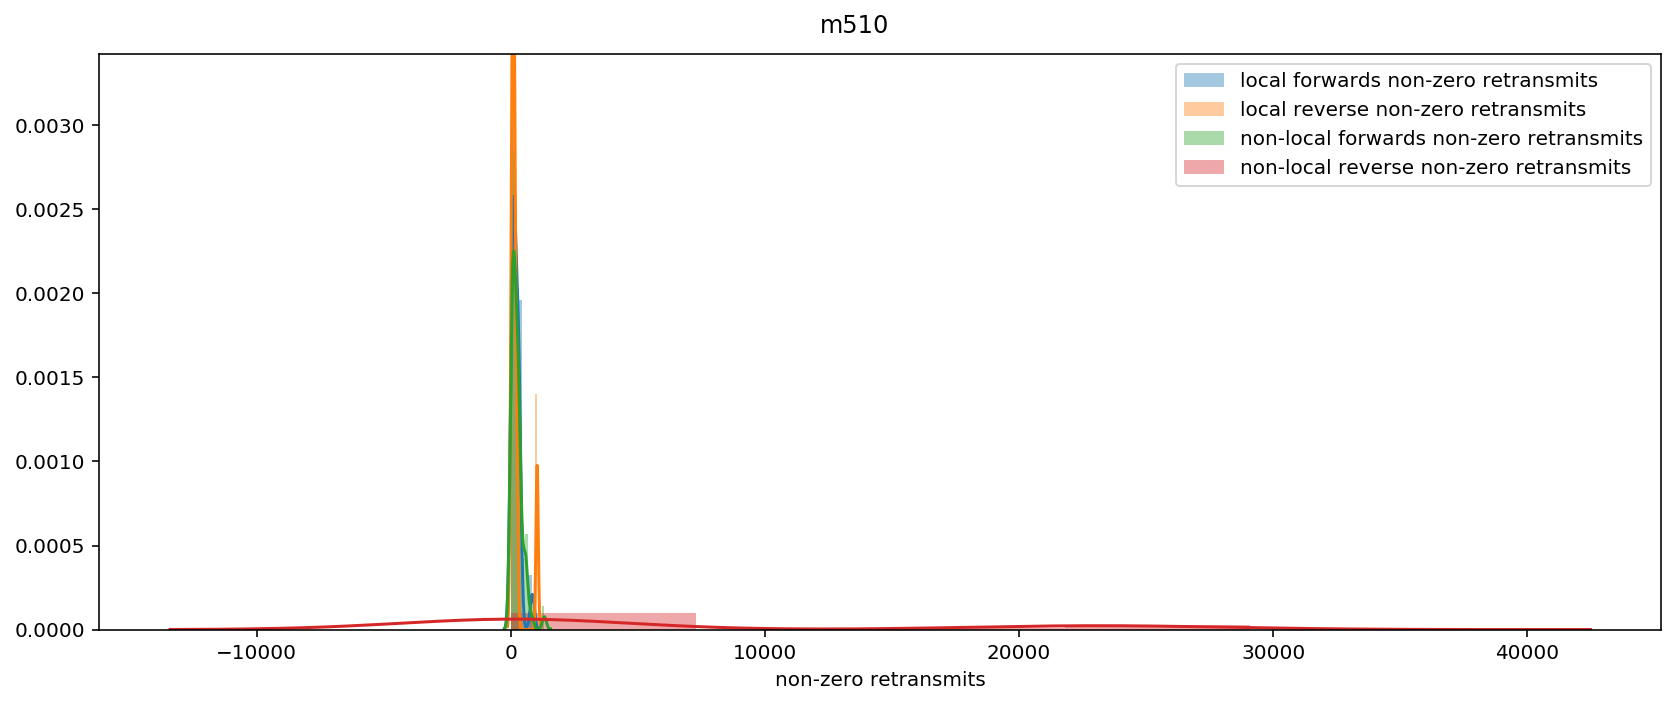

c6320 :
	Ratio of 0 retransmit runs/total runs:  522/754 69.2307692308%
	Average number of retransmits:  32.9151193634

	Non-local nodes:
		Ratio of 0 retransmit runs/total runs:  522/754 69.2307692308%
		Average number of retransmits:  32.9151193634

		Forwards runs:
			Ratio of 0 retransmit runs/total runs:  376/377 99.7347480106%
			Average number of retransmits:  0.0397877984085

		Reversed runs:
			Ratio of 0 retransmit runs/total runs:  146/377 38.7267904509%
			Average number of retransmits:  65.7904509284



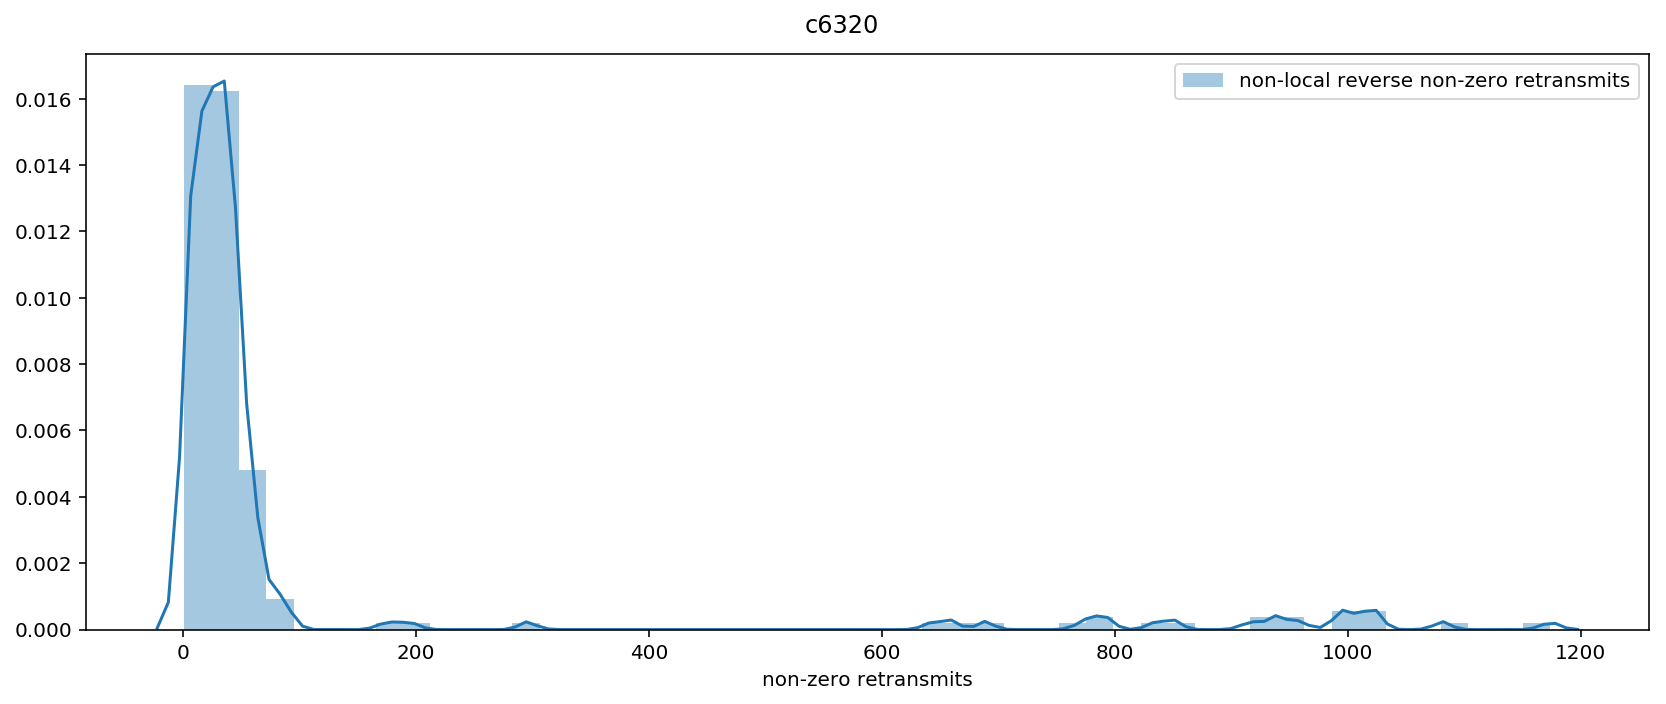

c220g1 :
	Ratio of 0 retransmit runs/total runs:  411/740 55.5405405405%
	Average number of retransmits:  19.8594594595

	Local nodes:
		Ratio of 0 retransmit runs/total runs:  86/144 59.7222222222%
		Average number of retransmits:  15.9236111111

		Forwards runs:
			Ratio of 0 retransmit runs/total runs:  29/72 40.2777777778%
			Average number of retransmits:  19.4861111111

		Reversed runs:
			Ratio of 0 retransmit runs/total runs:  57/72 79.1666666667%
			Average number of retransmits:  12.3611111111

	Non-local nodes:
		Ratio of 0 retransmit runs/total runs:  325/596 54.5302013423%
		Average number of retransmits:  20.8104026846

		Forwards runs:
			Ratio of 0 retransmit runs/total runs:  100/298 33.5570469799%
			Average number of retransmits:  26.9932885906

		Reversed runs:
			Ratio of 0 retransmit runs/total runs:  225/298 75.5033557047%
			Average number of retransmits:  14.6275167785



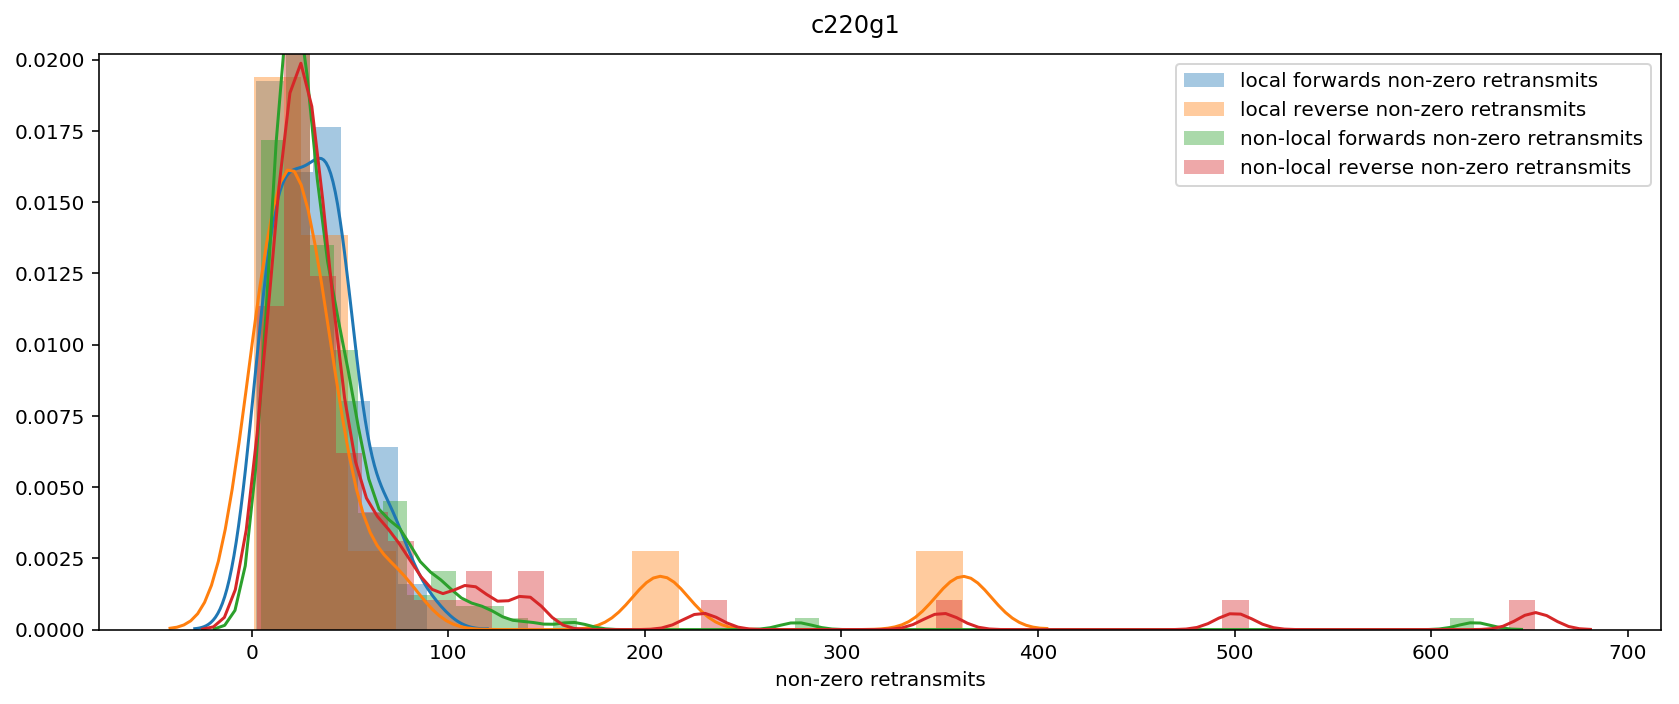

c8220 :
	Ratio of 0 retransmit runs/total runs:  1141/1412 80.8073654391%
	Average number of retransmits:  4.84065155807

	Local nodes:
		Ratio of 0 retransmit runs/total runs:  558/828 67.3913043478%
		Average number of retransmits:  8.03623188406

		Forwards runs:
			Ratio of 0 retransmit runs/total runs:  178/414 42.9951690821%
			Average number of retransmits:  12.6956521739

		Reversed runs:
			Ratio of 0 retransmit runs/total runs:  380/414 91.7874396135%
			Average number of retransmits:  3.3768115942

	Non-local nodes:
		Ratio of 0 retransmit runs/total runs:  583/584 99.8287671233%
		Average number of retransmits:  0.309931506849

		Forwards runs:
			Ratio of 0 retransmit runs/total runs:  292/292 100.0%
			Average number of retransmits:  0.0

		Reversed runs:
			Ratio of 0 retransmit runs/total runs:  291/292 99.6575342466%
			Average number of retransmits:  0.619863013699



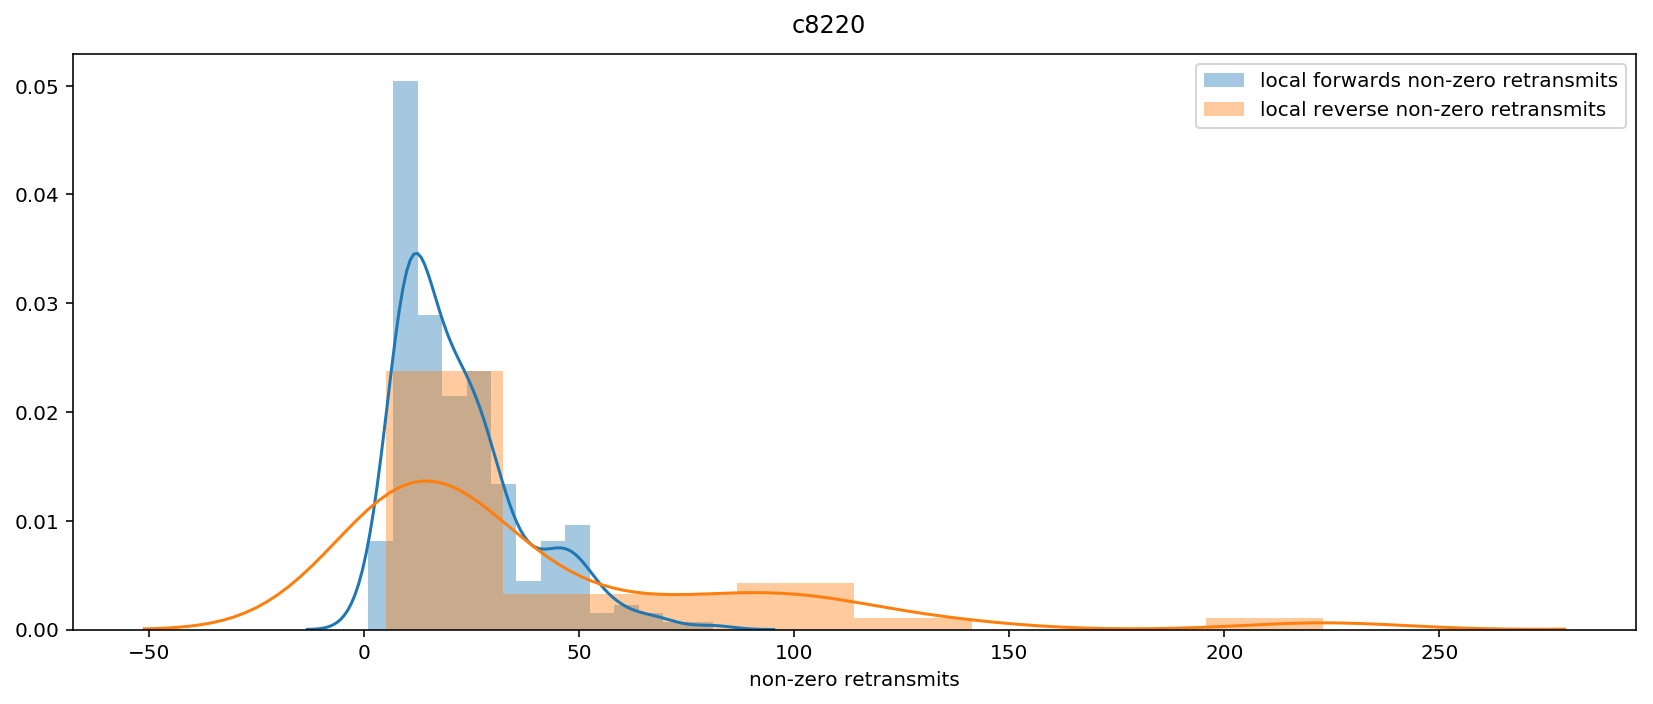

m400 :
	Ratio of 0 retransmit runs/total runs:  2222/2426 91.5910964551%
	Average number of retransmits:  121.93940643

	Non-local nodes:
		Ratio of 0 retransmit runs/total runs:  2222/2426 91.5910964551%
		Average number of retransmits:  121.93940643

		Forwards runs:
			Ratio of 0 retransmit runs/total runs:  1096/1213 90.3544929926%
			Average number of retransmits:  220.207749382

		Reversed runs:
			Ratio of 0 retransmit runs/total runs:  1126/1213 92.8276999176%
			Average number of retransmits:  23.671063479



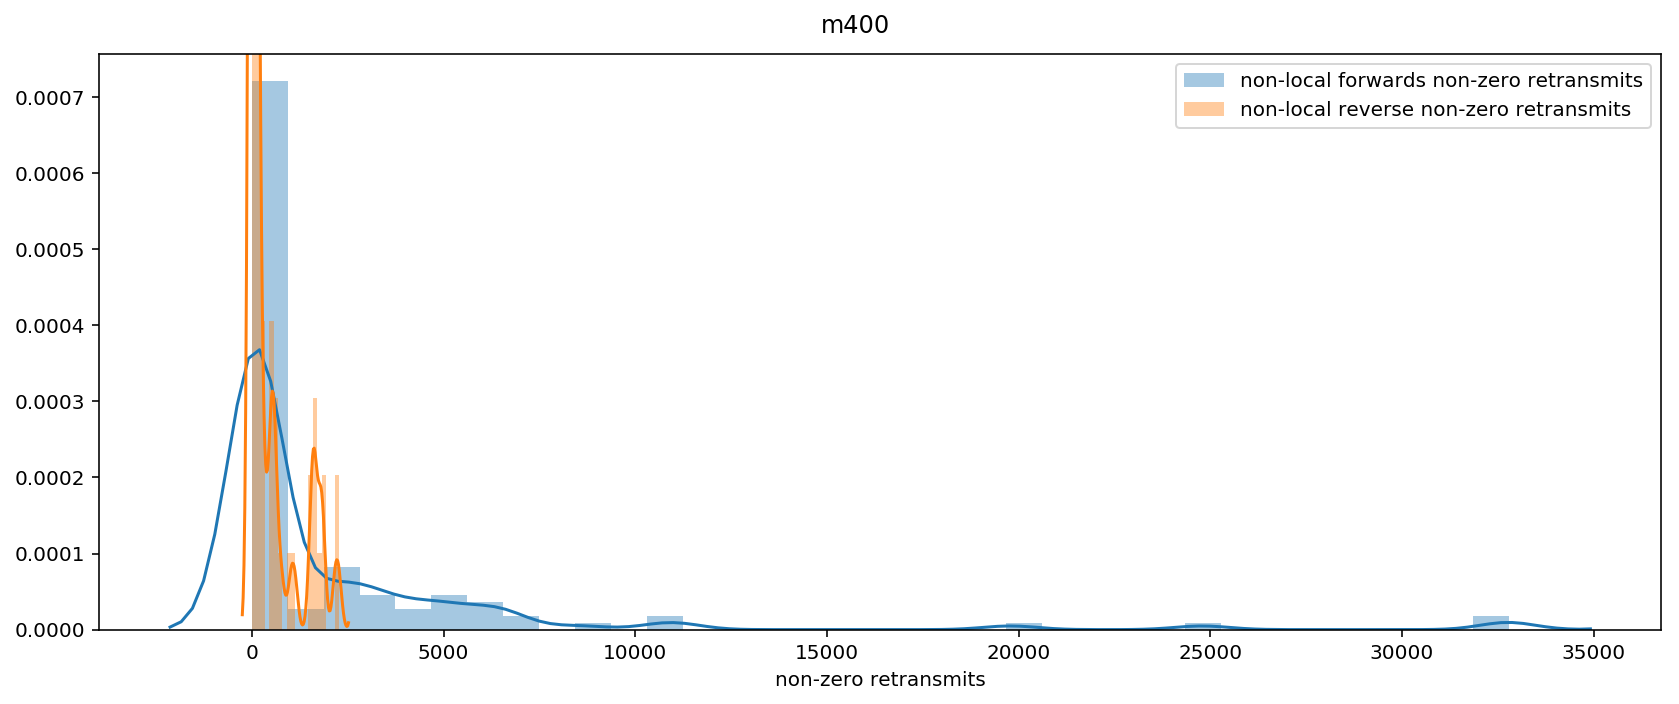

c220g2 :
	Ratio of 0 retransmit runs/total runs:  498/860 57.9069767442%
	Average number of retransmits:  23.9313953488

	Non-local nodes:
		Ratio of 0 retransmit runs/total runs:  498/860 57.9069767442%
		Average number of retransmits:  23.9313953488

		Forwards runs:
			Ratio of 0 retransmit runs/total runs:  144/430 33.488372093%
			Average number of retransmits:  29.2348837209

		Reversed runs:
			Ratio of 0 retransmit runs/total runs:  354/430 82.3255813953%
			Average number of retransmits:  18.6279069767



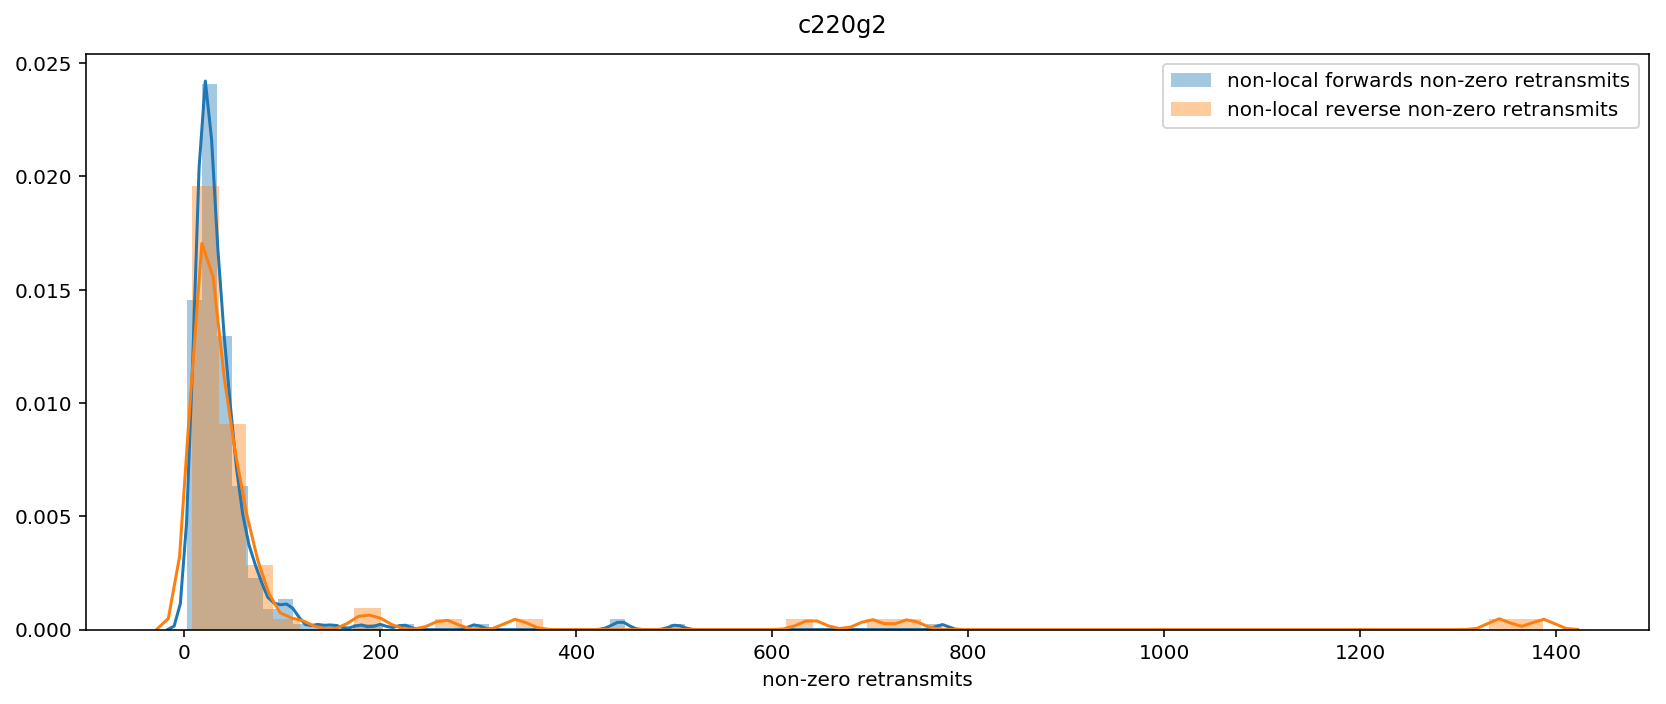

In [22]:
# Retransmits
# Breakdown by hw_type, locality, and direction
for hw_type in bw_all["hw_type"].unique():
    f, axarr = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(14, 5))
    site_df = subset_df(bw_all, {"hw_type": hw_type})
    site = site_df["site"].unique()[0]
    print hw_type,":"
    print "\tRatio of 0 retransmit runs/total runs:  " + \
          str(len(site_df[site_df["retransmits"] == 0])) + "/" + str(len(site_df)) + " " + \
          str(float(len(site_df[site_df["retransmits"] == 0]))*100/len(site_df)) + "%"
    print "\tAverage number of retransmits:  " + str(site_df["retransmits"].mean()) + "\n"
    
    if site == 'utah':
        plot_df = site_df[site_df['nodeid'].apply(is_local_utah)]
    elif site == 'wisc':
        plot_df = site_df[site_df['nodeid'].apply(is_local_wisc)]
    elif site == 'clemson':
        plot_df = site_df[site_df['nodeid'].apply(is_local_clemson)]
    if len(plot_df) > 0:
        print "\tLocal nodes:"
        print "\t\tRatio of 0 retransmit runs/total runs:  " + \
              str(len(plot_df[plot_df["retransmits"] == 0])) + "/" + str(len(plot_df)) + " " + \
              str(float(len(plot_df[plot_df["retransmits"] == 0]))*100/len(plot_df)) + "%"
        print "\t\tAverage number of retransmits:  " + str(plot_df["retransmits"].mean()) + "\n"
        forwards_df = plot_df[plot_df["reverse"] == 0]
        reverse_df = plot_df[plot_df["reverse"] == 1]
        print "\t\tForwards runs:"
        print "\t\t\tRatio of 0 retransmit runs/total runs:  " + \
              str(len(forwards_df[forwards_df["retransmits"] == 0])) + "/" + str(len(forwards_df)) + " " + \
              str(float(len(forwards_df[forwards_df["retransmits"] == 0]))*100/len(forwards_df)) + "%"
        print "\t\t\tAverage number of retransmits:  " + str(forwards_df["retransmits"].mean()) + "\n"
        print "\t\tReversed runs:"
        print "\t\t\tRatio of 0 retransmit runs/total runs:  " + \
              str(len(reverse_df[reverse_df["retransmits"] == 0])) + "/" + str(len(reverse_df)) + " " + \
              str(float(len(reverse_df[reverse_df["retransmits"] == 0]))*100/len(reverse_df)) + "%"
        print "\t\t\tAverage number of retransmits:  " + str(reverse_df["retransmits"].mean()) + "\n"
        #print plot_df["nodeid"].unique()
        forwards_df = forwards_df[forwards_df["retransmits"] > 0]
        reverse_df = reverse_df[reverse_df["retransmits"] > 0]
        if len(forwards_df) > 0:
            sns.distplot(forwards_df["retransmits"], ax=axarr, label="local forwards non-zero retransmits")
        if len(reverse_df) > 0:
            sns.distplot(reverse_df["retransmits"], ax=axarr, label="local reverse non-zero retransmits")
    
    if site == 'utah':
        plot_df = site_df[site_df['nodeid'].apply(is_not_local_utah)]
    elif site == 'wisc':
        plot_df = site_df[site_df['nodeid'].apply(is_not_local_wisc)]
    elif site == 'clemson':
        plot_df = site_df[site_df['nodeid'].apply(is_not_local_clemson)]
    if len(plot_df) > 0:
        print "\tNon-local nodes:"
        print "\t\tRatio of 0 retransmit runs/total runs:  " + \
              str(len(plot_df[plot_df["retransmits"] == 0])) + "/" + str(len(plot_df)) + " " + \
              str(float(len(plot_df[plot_df["retransmits"] == 0]))*100/len(plot_df)) + "%"
        print "\t\tAverage number of retransmits:  " + str(plot_df["retransmits"].mean()) + "\n"
        forwards_df = plot_df[plot_df["reverse"] == 0]
        reverse_df = plot_df[plot_df["reverse"] == 1]
        print "\t\tForwards runs:"
        print "\t\t\tRatio of 0 retransmit runs/total runs:  " + \
              str(len(forwards_df[forwards_df["retransmits"] == 0])) + "/" + str(len(forwards_df)) + " " + \
              str(float(len(forwards_df[forwards_df["retransmits"] == 0]))*100/len(forwards_df)) + "%"
        print "\t\t\tAverage number of retransmits:  " + str(forwards_df["retransmits"].mean()) + "\n"
        print "\t\tReversed runs:"
        print "\t\t\tRatio of 0 retransmit runs/total runs:  " + \
              str(len(reverse_df[reverse_df["retransmits"] == 0])) + "/" + str(len(reverse_df)) + " " + \
              str(float(len(reverse_df[reverse_df["retransmits"] == 0]))*100/len(reverse_df)) + "%"
        print "\t\t\tAverage number of retransmits:  " + str(reverse_df["retransmits"].mean()) + "\n"
        #print plot_df["nodeid"].unique()
        forwards_df = forwards_df[forwards_df["retransmits"] > 0]
        reverse_df = reverse_df[reverse_df["retransmits"] > 0]
        if len(forwards_df) > 1:
            sns.distplot(forwards_df["retransmits"], ax=axarr, label="non-local forwards non-zero retransmits")
        if len(reverse_df) > 1:
            sns.distplot(reverse_df["retransmits"], ax=axarr, label="non-local reverse non-zero retransmits")
    
    axarr.set(xlabel="non-zero retransmits")
    axarr.legend()
    f.suptitle(hw_type)
    f.subplots_adjust(top=.925)
    plot_show_and_save(f, show_only=True)

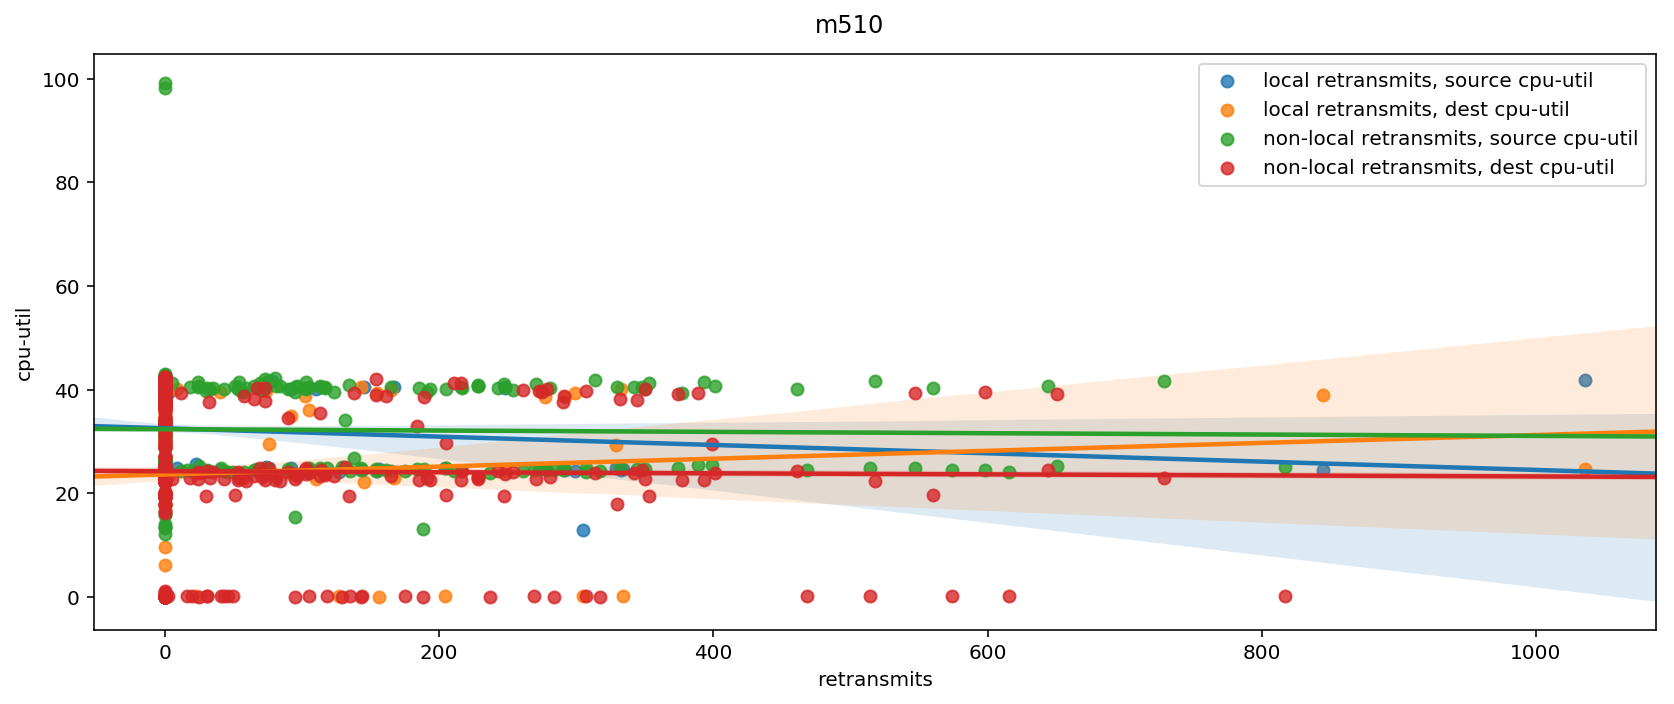

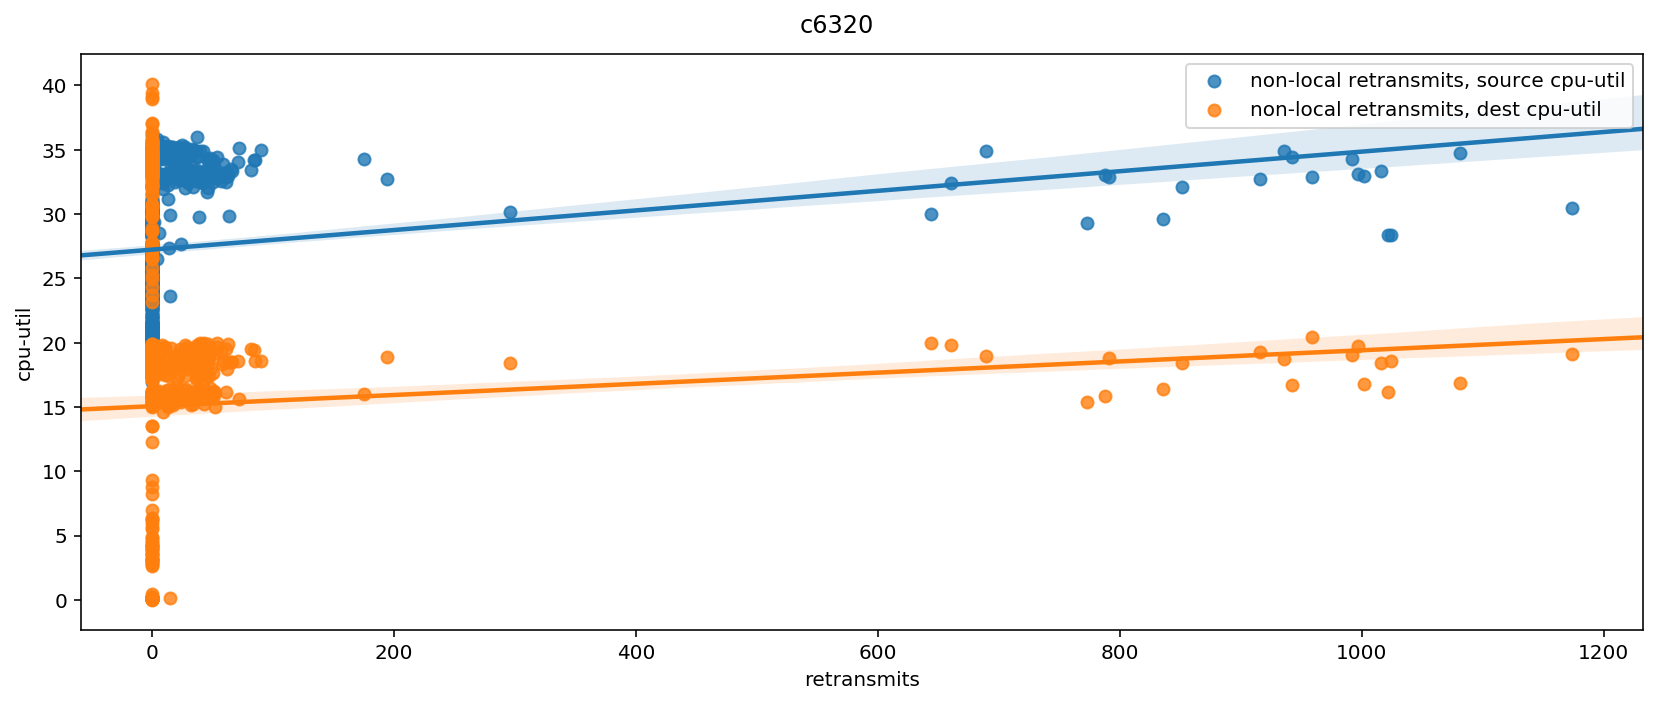

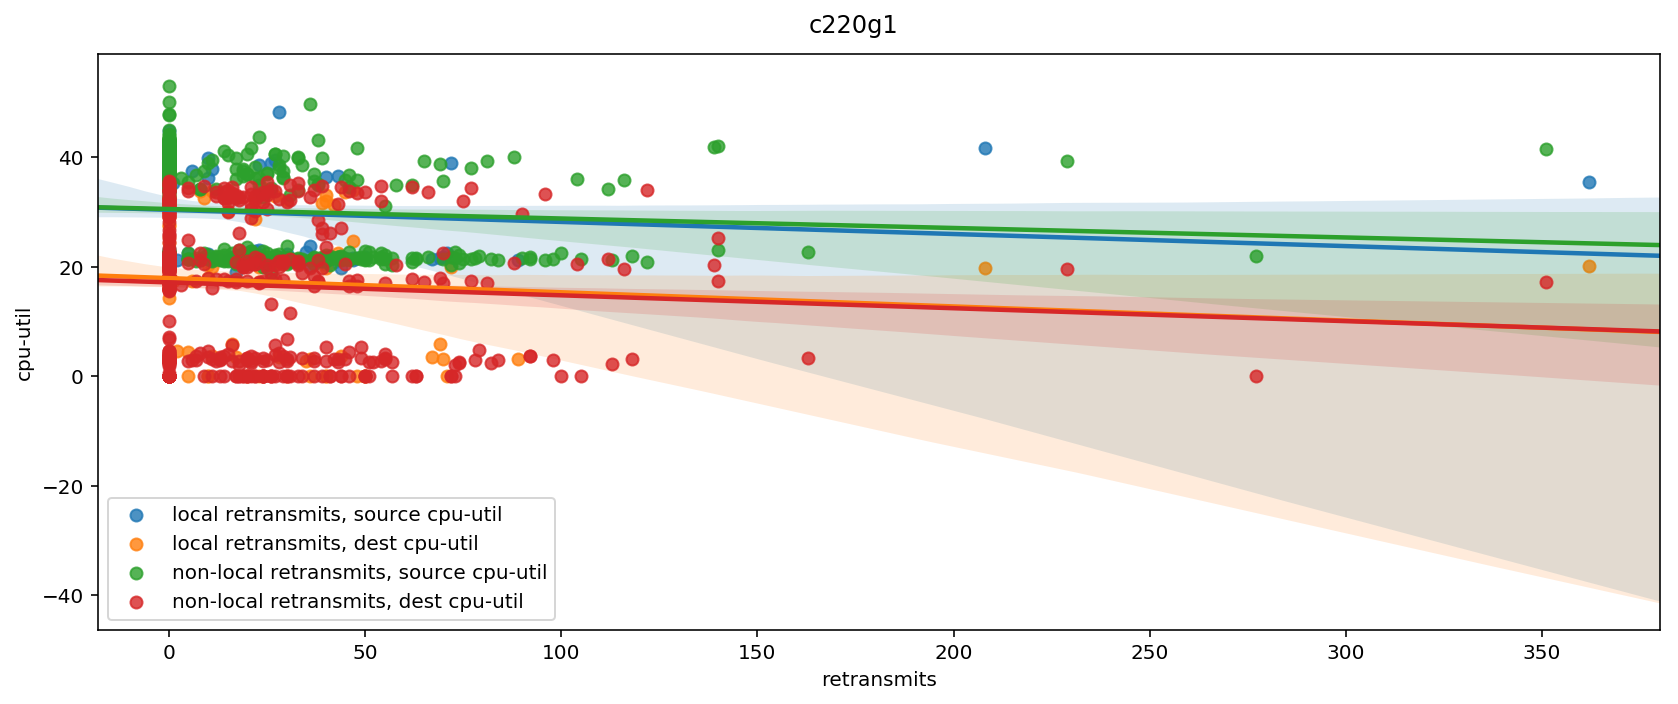

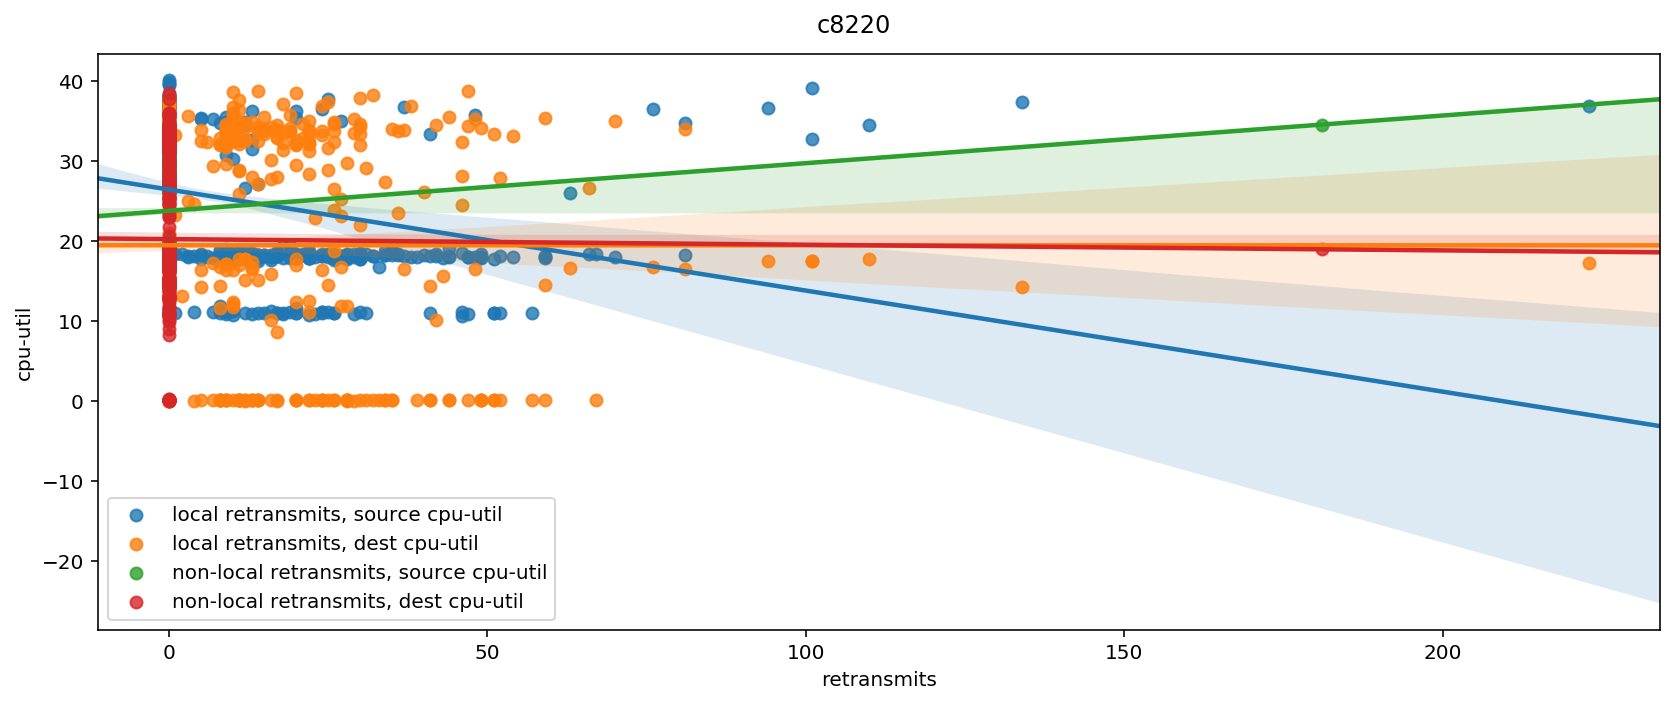

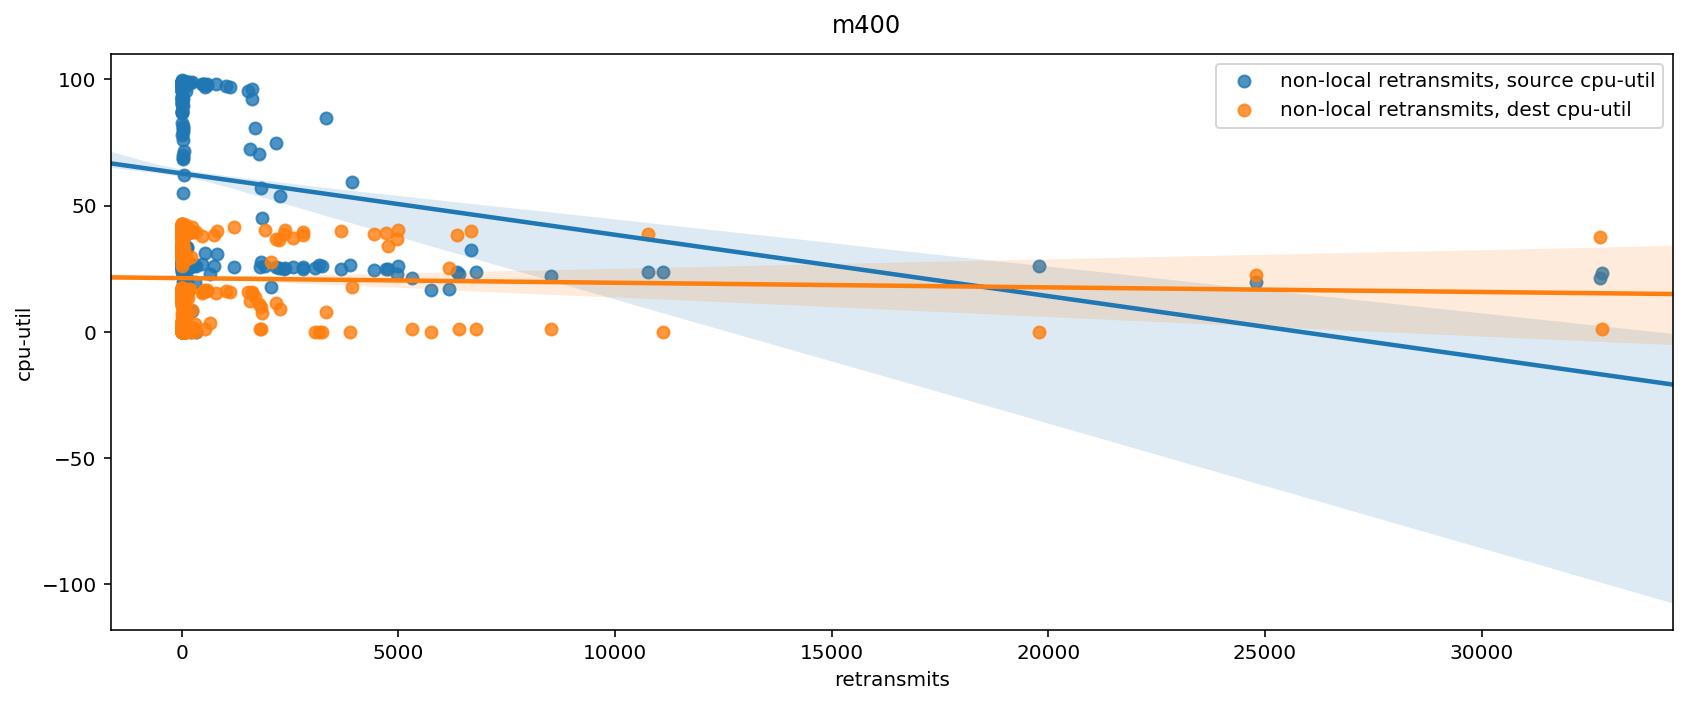

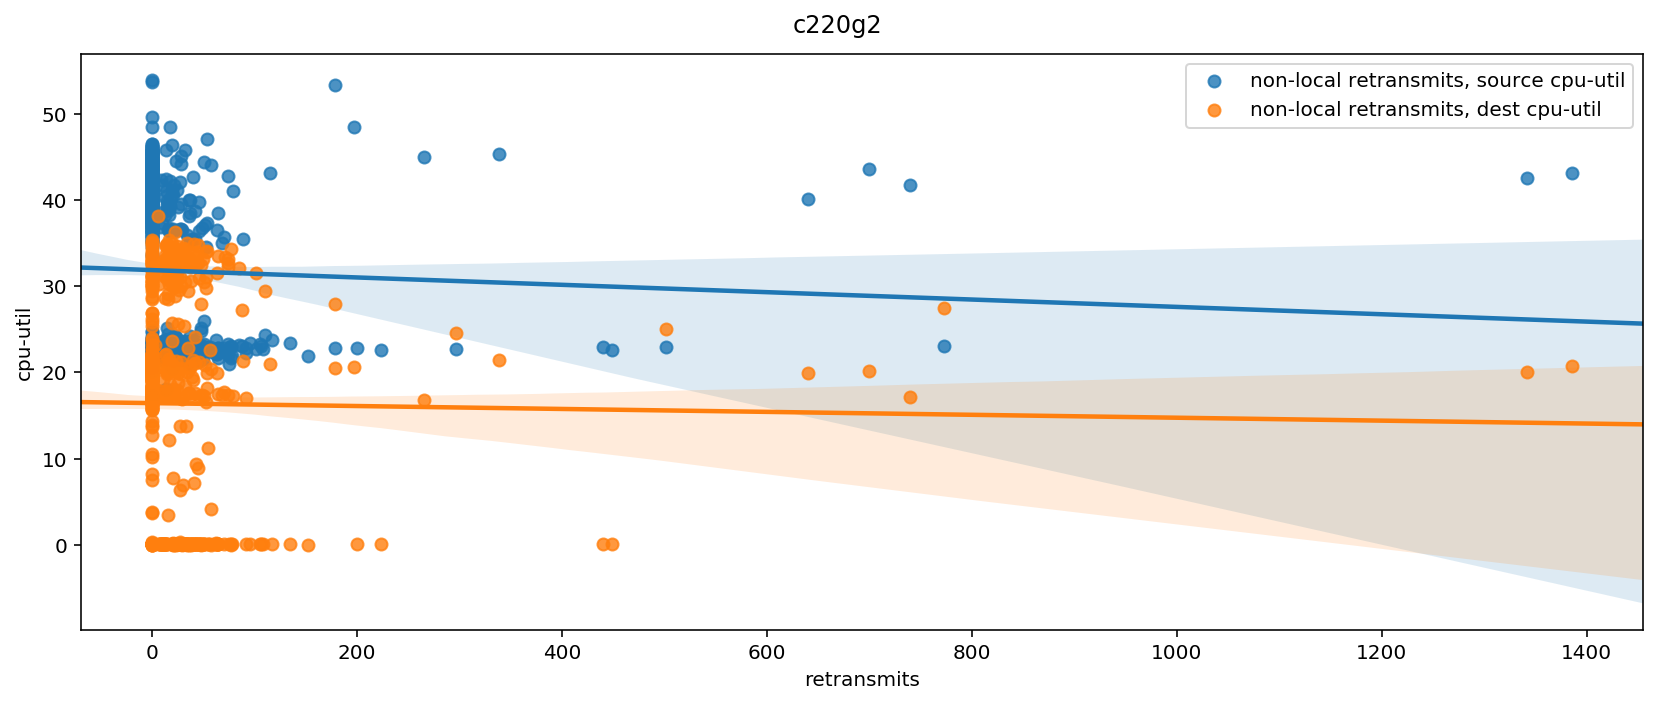

In [23]:
# Retransmits, scattered by cpu utilization
# Breakdown by hw_type and locality
for hw_type in bw_all["hw_type"].unique():
    f, axarr = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(14, 5))
    site_df = subset_df(bw_all, {"hw_type": hw_type})
    site = site_df["site"].unique()[0]
    
    if site == 'utah':
        plot_df = site_df[site_df['nodeid'].apply(is_local_utah)]
    elif site == 'wisc':
        plot_df = site_df[site_df['nodeid'].apply(is_local_wisc)]
    elif site == 'clemson':
        plot_df = site_df[site_df['nodeid'].apply(is_local_clemson)]
    if len(plot_df) > 0:
        sns.regplot(plot_df["retransmits"], plot_df["local_cpu_util"], ax=axarr, label="local retransmits, source cpu-util")
        sns.regplot(plot_df["retransmits"], plot_df["remote_cpu_util"], ax=axarr, label="local retransmits, dest cpu-util")
    
    if site == 'utah':
        plot_df = site_df[site_df['nodeid'].apply(is_not_local_utah)]
    elif site == 'wisc':
        plot_df = site_df[site_df['nodeid'].apply(is_not_local_wisc)]
    elif site == 'clemson':
        plot_df = site_df[site_df['nodeid'].apply(is_not_local_clemson)]
    if len(plot_df) > 0:
        sns.regplot(plot_df["retransmits"], plot_df["local_cpu_util"], ax=axarr, label="non-local retransmits, source cpu-util")
        sns.regplot(plot_df["retransmits"], plot_df["remote_cpu_util"], ax=axarr, label="non-local retransmits, dest cpu-util")
    
    axarr.set(xlabel="retransmits")
    axarr.set(ylabel="cpu-util")
    axarr.legend()
    f.suptitle(hw_type)
    f.subplots_adjust(top=.925)
    plot_show_and_save(f, show_only=True)

In [24]:
# Retransmits, breakdown by nodeid
for hw_type in bw_all["hw_type"].unique():
    f, axarr = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(14, 5))
    site_df = subset_df(bw_all, {"hw_type": hw_type})
    site = site_df["site"].unique()[0]
    print hw_type
    
    if site == 'utah':
        plot_df = site_df[site_df['nodeid'].apply(is_local_utah)]
    elif site == 'wisc':
        plot_df = site_df[site_df['nodeid'].apply(is_local_wisc)]
    elif site == 'clemson':
        plot_df = site_df[site_df['nodeid'].apply(is_local_clemson)]
    if len(plot_df) > 1:
        print "Local runs with retransmits/total:"
        for nodeid in plot_df["nodeid"].unique():
            node_df = subset_df(plot_df, {"nodeid":nodeid})
            forwards_df = subset_df(node_df, {"reverse":0})
            print "\tForwards", nodeid, len(forwards_df[forwards_df["retransmits"] > 0]), len(forwards_df)
            reverse_df = subset_df(node_df, {"reverse":1})
            print "\tReverse", nodeid, len(reverse_df[reverse_df["retransmits"] > 0]), len(reverse_df)
            
    if site == 'utah':
        plot_df = site_df[site_df['nodeid'].apply(is_not_local_utah)]
    elif site == 'wisc':
        plot_df = site_df[site_df['nodeid'].apply(is_not_local_wisc)]
    elif site == 'clemson':
        plot_df = site_df[site_df['nodeid'].apply(is_not_local_clemson)]
    if len(plot_df) > 1:
        print "Non-local runs with retransmits/total:"
        for nodeid in plot_df["nodeid"].unique():
            node_df = subset_df(plot_df, {"nodeid":nodeid})
            forwards_df = subset_df(node_df, {"reverse":0})
            print "\tForwards", nodeid, len(forwards_df[forwards_df["retransmits"] > 0]), len(forwards_df)
            reverse_df = subset_df(node_df, {"reverse":1})
            print "\tReverse", nodeid, len(reverse_df[reverse_df["retransmits"] > 0]), len(reverse_df)
            
    print "\n"

m510
Local runs with retransmits/total:
	Forwards ms0941 0 5
	Reverse ms0941 0 5
	Forwards ms0920 0 3
	Reverse ms0920 0 3
	Forwards ms0945 0 6
	Reverse ms0945 0 6
	Forwards ms0905 1 4
	Reverse ms0905 0 4
	Forwards ms0938 0 3
	Reverse ms0938 1 3
	Forwards ms0907 1 4
	Reverse ms0907 0 4
	Forwards ms0910 1 6
	Reverse ms0910 0 6
	Forwards ms0939 0 2
	Reverse ms0939 0 2
	Forwards ms0926 2 6
	Reverse ms0926 0 6
	Forwards ms0933 1 5
	Reverse ms0933 0 5
	Forwards ms0944 0 4
	Reverse ms0944 0 4
	Forwards ms0932 1 5
	Reverse ms0932 0 5
	Forwards ms0911 0 3
	Reverse ms0911 2 3
	Forwards ms0927 0 4
	Reverse ms0927 0 4
	Forwards ms0908 0 2
	Reverse ms0908 0 2
	Forwards ms0913 1 4
	Reverse ms0913 0 4
	Forwards ms0929 0 6
	Reverse ms0929 1 6
	Forwards ms0904 0 4
	Reverse ms0904 0 4
	Forwards ms0921 3 5
	Reverse ms0921 0 5
	Forwards ms0917 0 4
	Reverse ms0917 0 4
	Forwards ms0931 0 4
	Reverse ms0931 2 4
	Forwards ms0912 0 4
	Reverse ms0912 0 4
	Forwards ms0919 1 5
	Reverse ms0919 0 5
	Forwards ms0906 

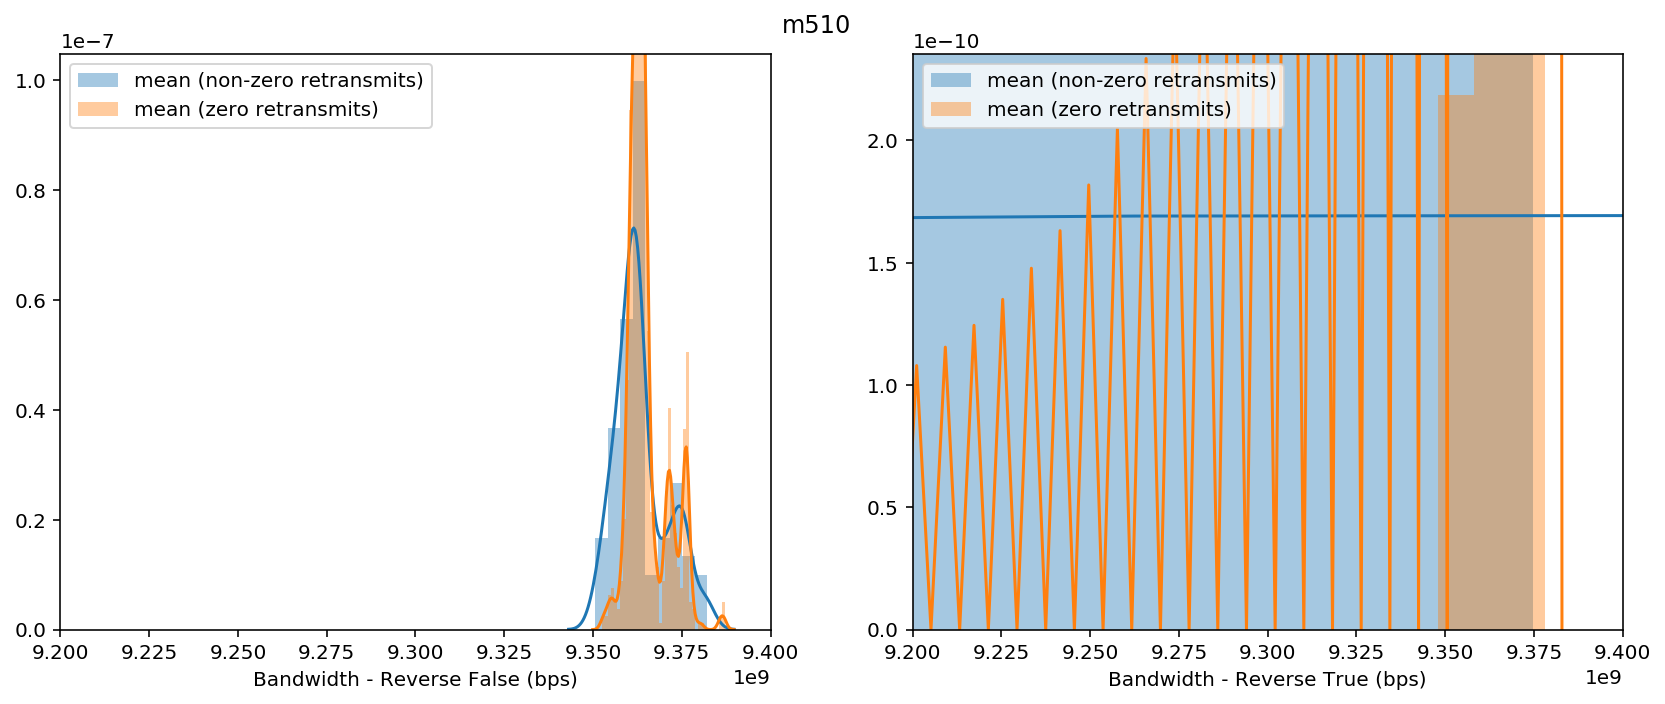

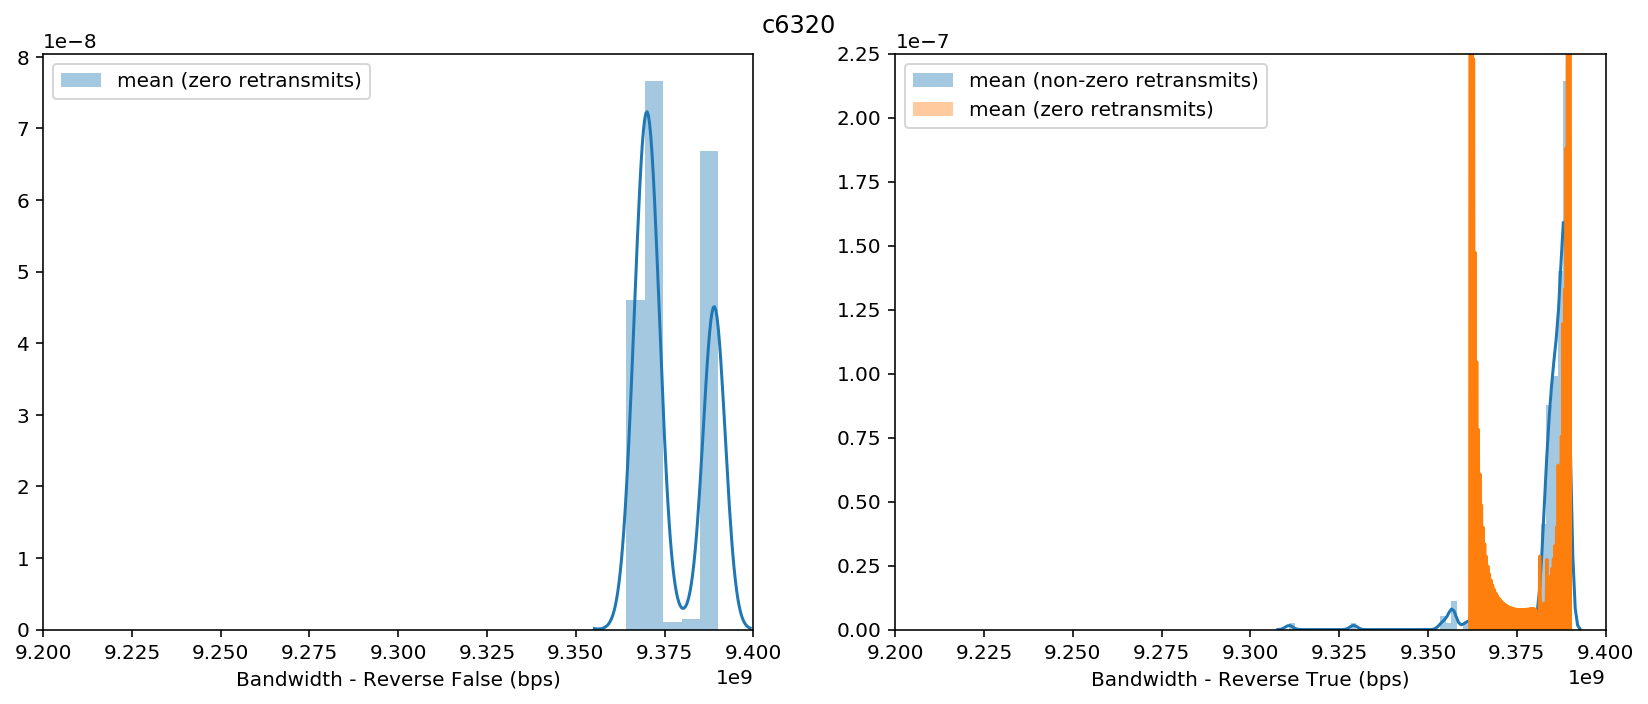

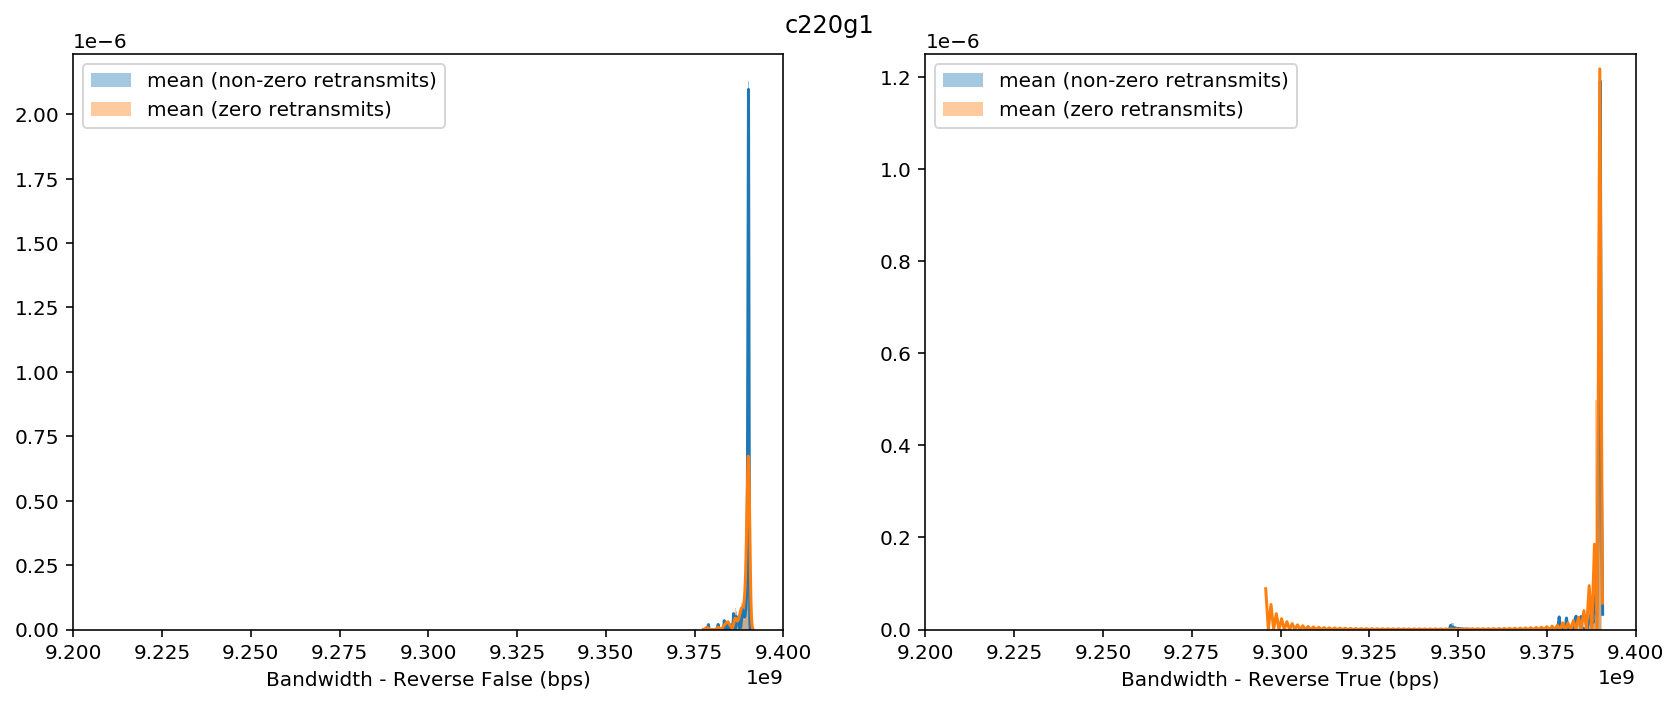

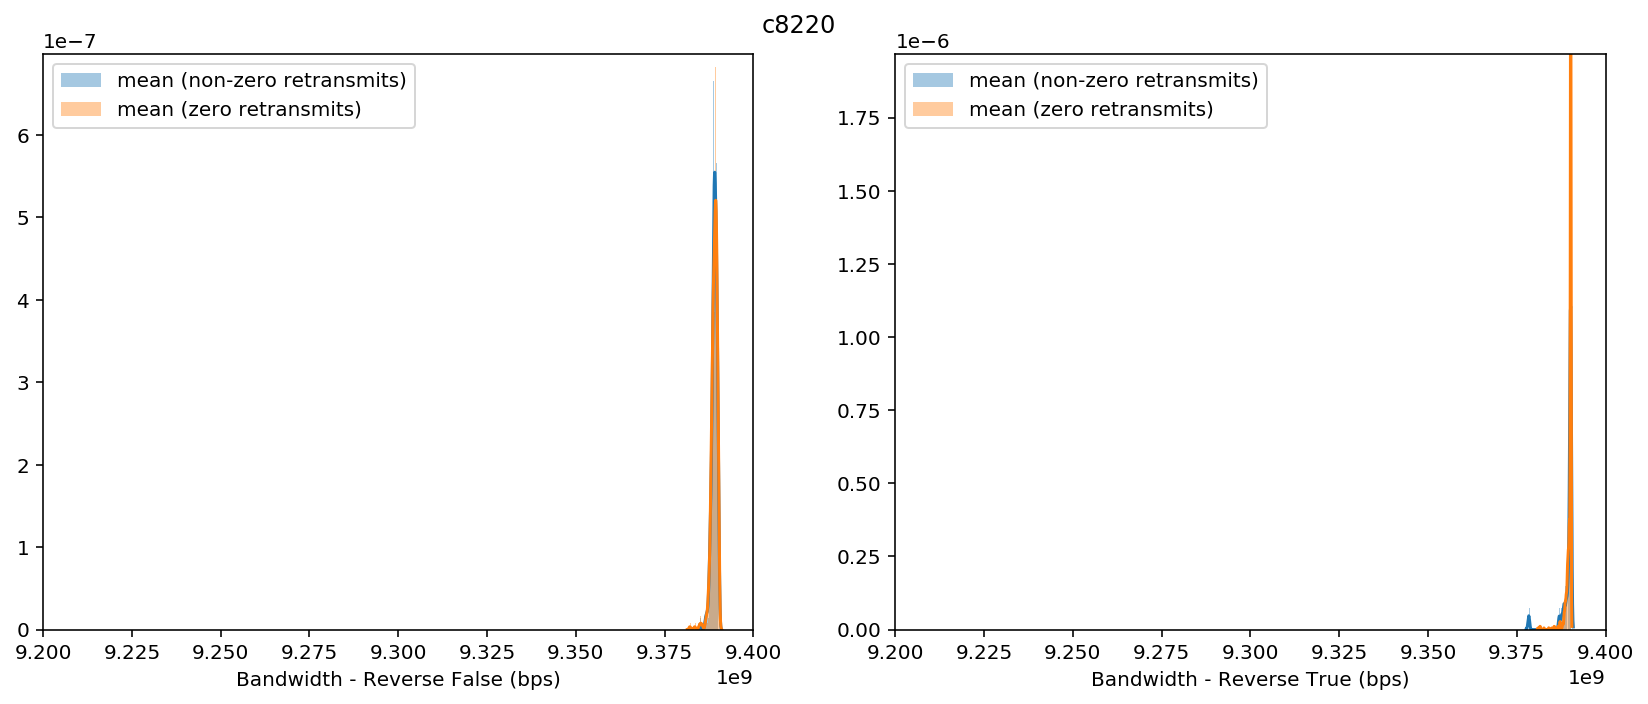

[8955970000.0, 4803060000.0, 2687670000.0]


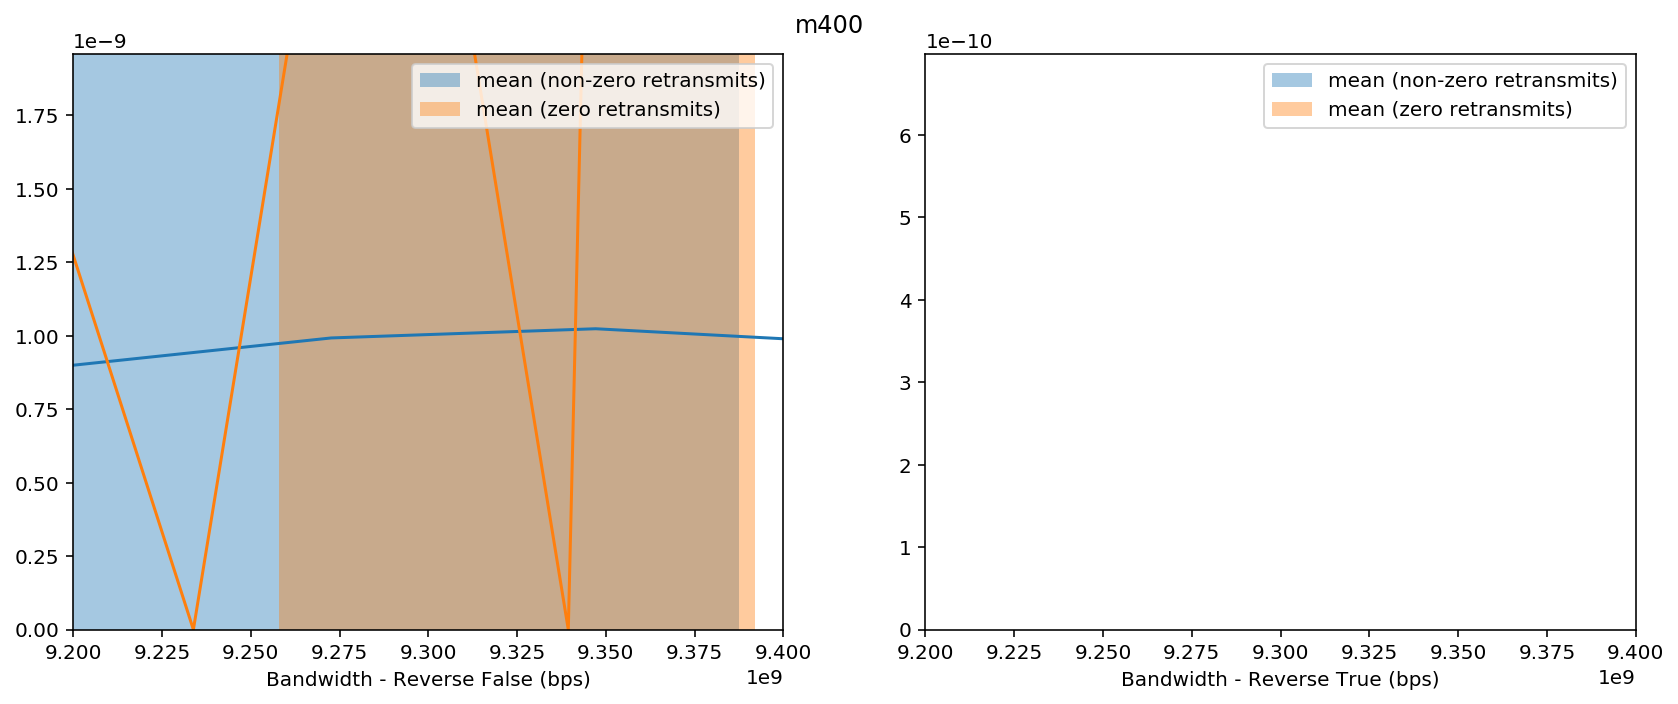

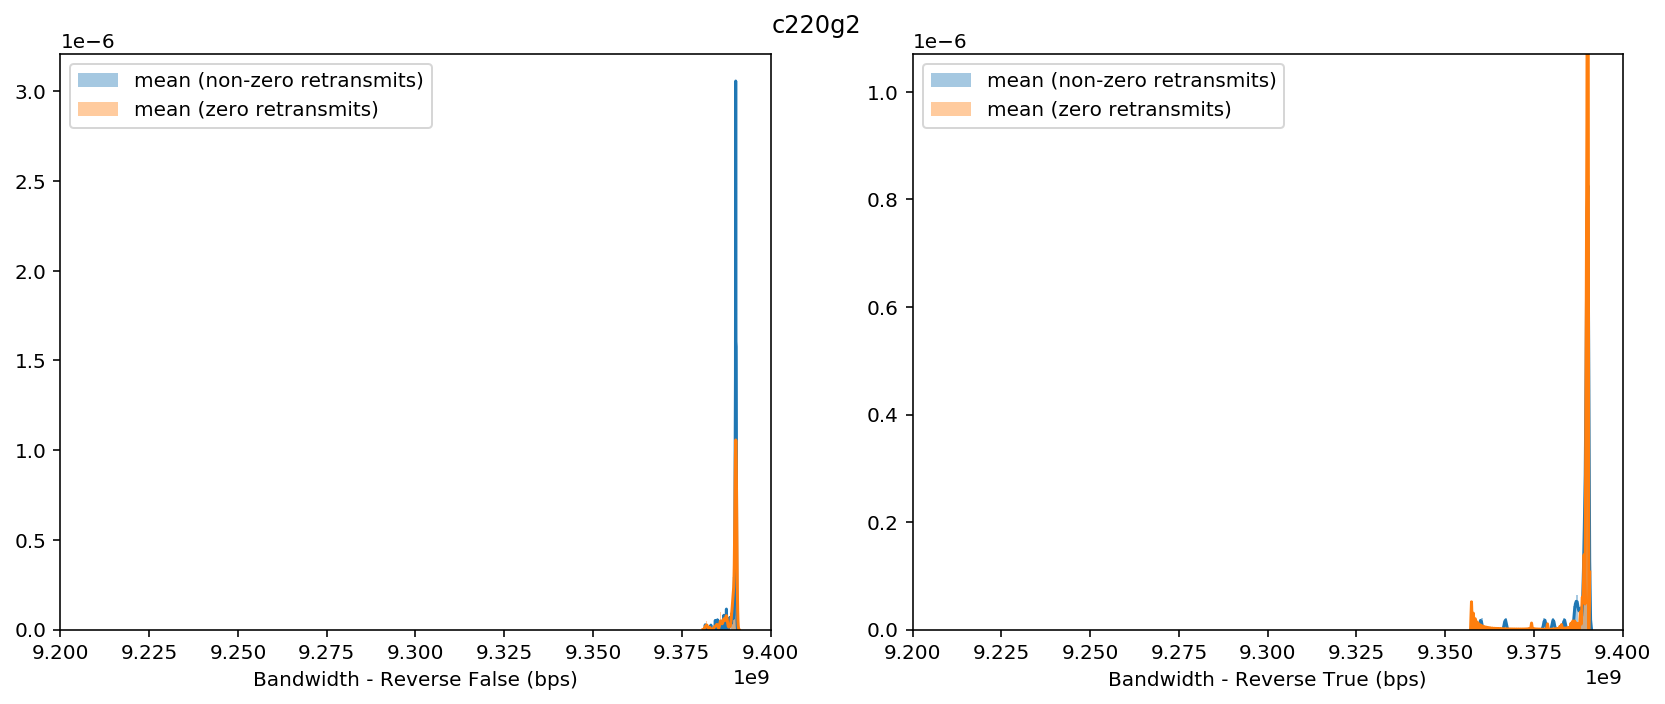

In [25]:
# Breakdown by hw_type, all categories
# Check bw difference between zero and non-zero retransmits
for hw_type in lat_all["hw_type"].unique():
    f, axarr = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(14, 5))
    for reverse in bw_all["reverse"].unique():
        dir_df = subset_df(bw_all, {"hw_type": hw_type, "reverse": reverse})
        plot_df = dir_df[dir_df["retransmits"] != 0]
        idx = int(reverse)
        if len(plot_df) > 1:
            sns.distplot(plot_df["mean"], ax=axarr[idx], label="mean (non-zero retransmits)")
        plot_df = dir_df[dir_df["retransmits"] == 0]
        if reverse == False and hw_type == "m400":
            print [x for x in plot_df["mean"] if x < 9.3e9]
        if len(plot_df) > 1:
            sns.distplot(plot_df["mean"], ax=axarr[idx], label="mean (zero retransmits)")
        axarr[idx].set(xlabel="Bandwidth - Reverse " + str(bool(reverse)) + " (bps)")
        axarr[idx].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        axarr[idx].set_xlim([9200000000,9400000000])
        axarr[idx].legend()
    f.suptitle(hw_type)
    f.subplots_adjust(top=.925)
    plot_show_and_save(f, show_only=True)